# import libraries

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D 
from matplotlib.patches import Wedge
import seaborn as sns
import geopandas as gpd
from pypinyin import lazy_pinyin, Style
#pip install pypinyin
import json
import urllib
import math
import matplotlib.patches as mpatches
from shapely.validation import explain_validity
import geopandas as gpd

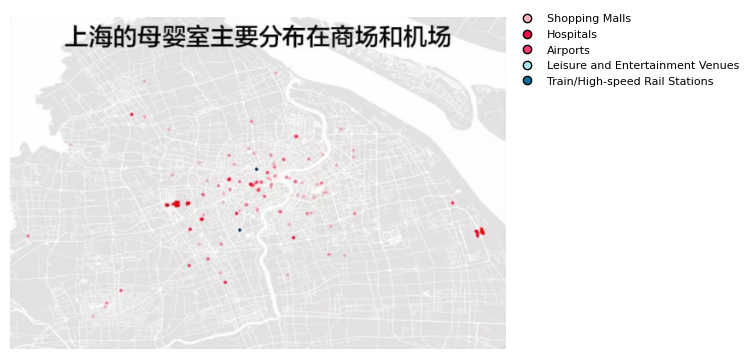

In [65]:
image_path = 'map_2019.png'
img = plt.imread(image_path)

fig, ax = plt.subplots()
ax.imshow(img)
ax.axis('off')

legend_labels = {
    'Shopping Malls': '#feb3be',
    'Hospitals': '#f4044a',
    'Airports': '#ff3d72',
    'Leisure and Entertainment Venues': '#ace4f0',
    'Train/High-speed Rail Stations': '#036e9c'
}

legend_dots = [plt.Line2D([0], [0], marker='o', color='none', markerfacecolor=color, markersize=6, label=label)
               for label, color in legend_labels.items()]

ax.legend(handles=legend_dots, loc='center left', bbox_to_anchor=(1, 0.9), frameon=False, fontsize=8)

plt.savefig('output/figure 4.8.png', dpi=300, bbox_inches='tight')

plt.show()


# transform coordinate

## define function

In [2]:
x_pi = 3.14159265358979324 * 3000.0 / 180.0
pi = 3.1415926535897932384626  # π
a = 6378245.0
ee = 0.00669342162296594323 

def bd09_to_gcj02(bd_lon, bd_lat):
    """
    BD-09 to GCJ-02
    :param bd_lat:BD-09 latitude
    :param bd_lon:BD-09 longitude
    :return: converted coordinates in a list format
    """
    x = bd_lon - 0.0065
    y = bd_lat - 0.006
    z = math.sqrt(x * x + y * y) - 0.00002 * math.sin(y * x_pi)
    theta = math.atan2(y, x) - 0.000003 * math.cos(x * x_pi)
    gg_lng = z * math.cos(theta)
    gg_lat = z * math.sin(theta)
    return [gg_lng, gg_lat]
def gcj02_to_wgs84(lng, lat):
    """
    GCJ02 to WGS84
    :param lng:GCJ02 latitude
    :param lat:GCJ02 longitude
    :return:
    """
    if out_of_china(lng, lat):
        return [lng, lat]
    dlat = _transformlat(lng - 105.0, lat - 35.0)
    dlng = _transformlng(lng - 105.0, lat - 35.0)
    radlat = lat / 180.0 * pi
    magic = math.sin(radlat)
    magic = 1 - ee * magic * magic
    sqrtmagic = math.sqrt(magic)
    dlat = (dlat * 180.0) / ((a * (1 - ee)) / (magic * sqrtmagic) * pi)
    dlng = (dlng * 180.0) / (a / sqrtmagic * math.cos(radlat) * pi)
    mglat = lat + dlat
    mglng = lng + dlng
    return [lng * 2 - mglng, lat * 2 - mglat]
def bd09_to_wgs84(bd_lon, bd_lat):
    lon, lat = bd09_to_gcj02(bd_lon, bd_lat)
    return gcj02_to_wgs84(lon, lat)
def bd09_to_wgs84(bd_lon, bd_lat):
    lon, lat = bd09_to_gcj02(bd_lon, bd_lat)
    return gcj02_to_wgs84(lon, lat)
def gcj02_to_bd09(lng, lat):
    """
    GCJ-02 to BD-09
    :param lng: GCJ-02 latitude
    :param lat: GCJ-02 longitude
    :return:
    """
    z = math.sqrt(lng * lng + lat * lat) + 0.00002 * math.sin(lat * x_pi)
    theta = math.atan2(lat, lng) + 0.000003 * math.cos(lng * x_pi)
    bd_lng = z * math.cos(theta) + 0.0065
    bd_lat = z * math.sin(theta) + 0.006
    return [bd_lng, bd_lat]
def wgs84_to_gcj02(lng, lat):
    """
    WGS84 to GCJ02 
    :param lng:WGS84 latitude 
    :param lat:WGS84 longitude
    :return:
    """
    if out_of_china(lng, lat): # Determine whether it is in China
        return [lng, lat]
    dlat = _transformlat(lng - 105.0, lat - 35.0)
    dlng = _transformlng(lng - 105.0, lat - 35.0)
    radlat = lat / 180.0 * pi
    magic = math.sin(radlat)
    magic = 1 - ee * magic * magic
    sqrtmagic = math.sqrt(magic)
    dlat = (dlat * 180.0) / ((a * (1 - ee)) / (magic * sqrtmagic) * pi)
    dlng = (dlng * 180.0) / (a / sqrtmagic * math.cos(radlat) * pi)
    mglat = lat + dlat
    mglng = lng + dlng
    return [mglng, mglat]
def wgs84_to_bd09(lon, lat):
    lon, lat = wgs84_to_gcj02(lon, lat)
    return gcj02_to_bd09(lon, lat)

def out_of_china(lng, lat):
    """
    Determine whether the coordinates are within mainland China. 
    If not, do not apply the offset; otherwise, apply the offset.
    :param lng:
    :param lat:
    :return:
    """
    return not (lng > 73.66 and lng < 135.05 and lat > 3.86 and lat < 53.55)

def _transformlng(lng, lat):
    ret = 300.0 + lng + 2.0 * lat + 0.1 * lng * lng + \
          0.1 * lng * lat + 0.1 * math.sqrt(math.fabs(lng))
    ret += (20.0 * math.sin(6.0 * lng * pi) + 20.0 *
            math.sin(2.0 * lng * pi)) * 2.0 / 3.0
    ret += (20.0 * math.sin(lng * pi) + 40.0 *
            math.sin(lng / 3.0 * pi)) * 2.0 / 3.0
    ret += (150.0 * math.sin(lng / 12.0 * pi) + 300.0 *
            math.sin(lng / 30.0 * pi)) * 2.0 / 3.0
    return ret
def _transformlat(lng, lat):
    ret = -100.0 + 2.0 * lng + 3.0 * lat + 0.2 * lat * lat + \
          0.1 * lng * lat + 0.2 * math.sqrt(math.fabs(lng))
    ret += (20.0 * math.sin(6.0 * lng * pi) + 20.0 *
            math.sin(2.0 * lng * pi)) * 2.0 / 3.0
    ret += (20.0 * math.sin(lat * pi) + 40.0 *
            math.sin(lat / 3.0 * pi)) * 2.0 / 3.0
    ret += (160.0 * math.sin(lat / 12.0 * pi) + 320 *
            math.sin(lat * pi / 30.0)) * 2.0 / 3.0
    return ret

## shopping malls

In [3]:
shopping_malls_2023_path = 'Output/shopping_malls_2023.csv'
shopping_malls_2023 = pd.read_csv(shopping_malls_2023_path, encoding='utf-8-sig')
shopping_malls_2023_1 = shopping_malls_2023.copy()
shopping_malls_2023_1.head()

name      location    location_1 date         time services  \
0   1788购物中心  南京西路1788号商场内     南京西路1788号  1-7  10:00-22:00      母婴室   
1      818广场   南京西路818号商场内   南京西路818号商场内  1-7  10:00-22:00      母婴室   
2       96广场    东方路796号商场内    东方路796号商场内  1-7  10:00-22:00      母婴室   
3  BFC外滩金融中心  中山东二路600号商场内  中山东二路600号商场内  1-7  10:00-22:00      母婴室   
4  K11购物艺术中心    淮海中路300号B1      淮海中路300号  1-7  10:00-22:00      母婴室   

    longitude   latitude  
0  121.450014  31.228803  
1  121.467370  31.237311  
2  121.531251  31.233406  
3  121.504905  31.231625  
4  121.453050  31.215039

In [4]:
shopping_malls_2023_1[['longitude_wgs84', 'latitude_wgs84']] = shopping_malls_2023_1.apply(
    lambda row: bd09_to_wgs84(row['longitude'], row['latitude']), axis=1, result_type='expand'
)

shopping_malls_2023_1.head()

name      location    location_1 date         time services  \
0   1788购物中心  南京西路1788号商场内     南京西路1788号  1-7  10:00-22:00      母婴室   
1      818广场   南京西路818号商场内   南京西路818号商场内  1-7  10:00-22:00      母婴室   
2       96广场    东方路796号商场内    东方路796号商场内  1-7  10:00-22:00      母婴室   
3  BFC外滩金融中心  中山东二路600号商场内  中山东二路600号商场内  1-7  10:00-22:00      母婴室   
4  K11购物艺术中心    淮海中路300号B1      淮海中路300号  1-7  10:00-22:00      母婴室   

    longitude   latitude  longitude_wgs84  latitude_wgs84  
0  121.450014  31.228803       121.438983       31.224317  
1  121.467370  31.237311       121.456332       31.233047  
2  121.531251  31.233406       121.520363       31.229593  
3  121.504905  31.231625       121.493856       31.227999  
4  121.453050  31.215039       121.442032       31.210582

In [5]:
shopping_malls_2023_1.shape

(455, 10)

## hospitals

In [6]:
hospitals_2023_path = 'Output/hospitals_2023.csv'
hospitals_2023 = pd.read_csv(hospitals_2023_path, encoding='utf-8-sig')
hospitals_2023_1 = hospitals_2023.copy()
hospitals_2023_1.head()

name                        location  \
0           85医院             上海市华山路1328号住院部二楼电梯口   
1           85医院           上海市华山路1328号住院部二楼妇产科病区   
2  安亭镇黄渡社区卫生服务中心         上海市嘉定区新黄路10号2号楼底楼儿童卫生间内   
3  安亭镇黄渡社区卫生服务中心            嘉定区安亭镇新黄路10号2号楼2楼母婴室   
4    安亭镇社区卫生服务中心  上海市民丰路1200号二楼预防接种门诊旁（靠近无障碍卫生间）   

                       location_1 date         time  \
0                  上海市华山路1328号住院部  1-7  08:00-18:00   
1                  上海市华山路1328号住院部  1-7  08:00-18:00   
2                 上海市嘉定区新黄路10号2号楼  1-5  08:00-16:30   
3                 嘉定区安亭镇新黄路10号2号楼  1-5  08:30-16:30   
4  上海市民丰路1200号二楼预防接种门诊旁（靠近无障碍卫生间）  1-5  07:50-16:30   

                                            services   longitude   latitude  
0                                婴儿喂哺、婴儿护理（换尿布）、孕妇休息  121.439109  31.215806  
1                                婴儿喂哺、婴儿护理（换尿布）、孕妇休息  121.439109  31.215806  
2                                     婴儿喂哺、婴儿护理（换尿布）  121.224768  31.276132  
3  带安全扣的婴儿尿布台、提供水和洗手液的洗手台、便于哺乳休息的座椅、便于放置哺乳有关用品的桌子...  121.224768  31.276132  
4                                          婴儿护理（换尿布）  121.154367  31.312073

In [7]:
hospitals_2023_1[['longitude_wgs84', 'latitude_wgs84']] = hospitals_2023_1.apply(
    lambda row: bd09_to_wgs84(row['longitude'], row['latitude']), axis=1, result_type='expand'
)

hospitals_2023_1.head()

name                        location  \
0           85医院             上海市华山路1328号住院部二楼电梯口   
1           85医院           上海市华山路1328号住院部二楼妇产科病区   
2  安亭镇黄渡社区卫生服务中心         上海市嘉定区新黄路10号2号楼底楼儿童卫生间内   
3  安亭镇黄渡社区卫生服务中心            嘉定区安亭镇新黄路10号2号楼2楼母婴室   
4    安亭镇社区卫生服务中心  上海市民丰路1200号二楼预防接种门诊旁（靠近无障碍卫生间）   

                       location_1 date         time  \
0                  上海市华山路1328号住院部  1-7  08:00-18:00   
1                  上海市华山路1328号住院部  1-7  08:00-18:00   
2                 上海市嘉定区新黄路10号2号楼  1-5  08:00-16:30   
3                 嘉定区安亭镇新黄路10号2号楼  1-5  08:30-16:30   
4  上海市民丰路1200号二楼预防接种门诊旁（靠近无障碍卫生间）  1-5  07:50-16:30   

                                            services   longitude   latitude  \
0                                婴儿喂哺、婴儿护理（换尿布）、孕妇休息  121.439109  31.215806   
1                                婴儿喂哺、婴儿护理（换尿布）、孕妇休息  121.439109  31.215806   
2                                     婴儿喂哺、婴儿护理（换尿布）  121.224768  31.276132   
3  带安全扣的婴儿尿布台、提供水和洗手液的洗手台、便于哺乳休息的座椅、便于放置哺乳有关用品的桌子...  121.224768  31.276132   
4                                          婴儿护理（换尿布）  121.154367  31.312073   

   longitude_wgs84  latitude_wgs84  
0       121.428061       31.211332  
1       121.428061       31.211332  
2       121.213886       31.271912  
3       121.213886       31.271912  
4       121.143216       31.308263

In [8]:
hospitals_2023_1.shape

(459, 10)

## airports

In [9]:
airports_2023_path = 'Output/airports_2023.csv'
airports_2023 = pd.read_csv(airports_2023_path, encoding='utf-8-sig')
airports_2023_1 = airports_2023.copy()
airports_2023_1.head()

name                  location   location_1 date         time  \
0  虹桥T2航站楼A岛母婴室    上海市T2航站楼3楼A岛母婴室（近浦发银行）    上海市申达一路1号  1-7  05:30-23:00   
1     虹桥机场1号航站楼        上海市虹桥路2550号出发5号门附近  上海市虹桥路2550号  1-7  06:00-24:00   
2     虹桥机场1号航站楼       上海市虹桥路2550号T10登机口附近  上海市虹桥路2550号  1-7  06:00-24:00   
3     虹桥机场1号航站楼      上海市虹桥路2550号到达行李寄存处附近  上海市虹桥路2550号  1-7  06:00-24:00   
4     虹桥机场1号航站楼  上海市虹桥路2550号到达禁区外（员工通道附近）  上海市虹桥路2550号  1-7  06:00-24:00   

                                            services   longitude   latitude  
0                                         婴儿换尿布台、休息室  121.333743  31.201898  
1                婴儿护理（换尿布）、哺乳座椅、洗手台、擦手纸、洗手液、垃圾桶、电源插座  121.354795  31.193250  
2  多种水温选择的净水器、婴儿护理（换尿布）、哺乳桌、哺乳沙发、洗手干手一体机、擦手纸、洗手液、...  121.354795  31.193250  
3                婴儿护理（换尿布）、哺乳座椅、洗手台、擦手纸、洗手液、垃圾桶、电源插座  121.354795  31.193250  
4                婴儿护理（换尿布）、哺乳座椅、洗手台、擦手纸、洗手液、垃圾桶、电源插座  121.354795  31.193250

In [10]:
airports_2023_1[['longitude_wgs84', 'latitude_wgs84']] = airports_2023_1.apply(
    lambda row: bd09_to_wgs84(row['longitude'], row['latitude']), axis=1, result_type='expand'
)

airports_2023_1.head()

name                  location   location_1 date         time  \
0  虹桥T2航站楼A岛母婴室    上海市T2航站楼3楼A岛母婴室（近浦发银行）    上海市申达一路1号  1-7  05:30-23:00   
1     虹桥机场1号航站楼        上海市虹桥路2550号出发5号门附近  上海市虹桥路2550号  1-7  06:00-24:00   
2     虹桥机场1号航站楼       上海市虹桥路2550号T10登机口附近  上海市虹桥路2550号  1-7  06:00-24:00   
3     虹桥机场1号航站楼      上海市虹桥路2550号到达行李寄存处附近  上海市虹桥路2550号  1-7  06:00-24:00   
4     虹桥机场1号航站楼  上海市虹桥路2550号到达禁区外（员工通道附近）  上海市虹桥路2550号  1-7  06:00-24:00   

                                            services   longitude   latitude  \
0                                         婴儿换尿布台、休息室  121.333743  31.201898   
1                婴儿护理（换尿布）、哺乳座椅、洗手台、擦手纸、洗手液、垃圾桶、电源插座  121.354795  31.193250   
2  多种水温选择的净水器、婴儿护理（换尿布）、哺乳桌、哺乳沙发、洗手干手一体机、擦手纸、洗手液、...  121.354795  31.193250   
3                婴儿护理（换尿布）、哺乳座椅、洗手台、擦手纸、洗手液、垃圾桶、电源插座  121.354795  31.193250   
4                婴儿护理（换尿布）、哺乳座椅、洗手台、擦手纸、洗手液、垃圾桶、电源插座  121.354795  31.193250   

   longitude_wgs84  latitude_wgs84  
0       121.322796       31.197506  
1       121.343731       31.189131  
2       121.343731       31.189131  
3       121.343731       31.189131  
4       121.343731       31.189131

In [11]:
airports_2023_1.shape

(120, 10)

## bus stations

In [12]:
bus_stations_2023_path = 'Output/bus_stations_2023.csv'
bus_stations_2023 = pd.read_csv(bus_stations_2023_path, encoding='utf-8-sig')
bus_stations_2023_1 = bus_stations_2023.copy()
bus_stations_2023_1.head()

name                  location                location_1 date  \
0        崇明巴士公司南门汽车站  崇明区城桥镇八一路11号南门汽车站西门进口处西侧  崇明区城桥镇八一路11号南门汽车站西门进口处西侧  1-5   
1       崇明巴士公司水陆换乘中心   崇明区城桥镇南门支路45号水陆换乘中心厕所对面   崇明区城桥镇南门支路45号水陆换乘中心厕所对面  1-5   
2        崇明巴士公司长途汽车站    崇明区城桥镇西门路8号长途汽车站南侧售票处边          崇明区城桥镇西门路8号长途汽车站  1-5   
3  金高公交五洲大道枢纽站爱心妈咪小屋   张杨北路2599号售票室东侧\n乘客候车廊西侧                 张杨北路2575号  1-7   
4           交运巴士妈咪小屋      上海市浦东新区高科西路562号东站候车厅           上海市浦东新区高科西路562号  1-7   

          time                            services   longitude   latitude  
0  08:30-16:30                      婴儿喂养、婴儿护理（换尿布）  121.401157  31.623126  
1  08:30-16:30                      婴儿喂养、婴儿护理（换尿布）  121.399147  31.623881  
2  08:30-16:30                      婴儿喂养、婴儿护理（换尿布）  121.398941  31.625561  
3  06:20-21:00  有私密空间、热水、尿布、湿巾等，供女职工及女乘客休息、哺乳、更换尿布  121.595379  31.307250  
4  07:00-19:00                       婴儿换尿布台、冰箱、休息室  121.510730  31.189653

In [13]:
bus_stations_2023_1[['longitude_wgs84', 'latitude_wgs84']] = bus_stations_2023_1.apply(
    lambda row: bd09_to_wgs84(row['longitude'], row['latitude']), axis=1, result_type='expand'
)

bus_stations_2023_1.head()

name                  location                location_1 date  \
0        崇明巴士公司南门汽车站  崇明区城桥镇八一路11号南门汽车站西门进口处西侧  崇明区城桥镇八一路11号南门汽车站西门进口处西侧  1-5   
1       崇明巴士公司水陆换乘中心   崇明区城桥镇南门支路45号水陆换乘中心厕所对面   崇明区城桥镇南门支路45号水陆换乘中心厕所对面  1-5   
2        崇明巴士公司长途汽车站    崇明区城桥镇西门路8号长途汽车站南侧售票处边          崇明区城桥镇西门路8号长途汽车站  1-5   
3  金高公交五洲大道枢纽站爱心妈咪小屋   张杨北路2599号售票室东侧\n乘客候车廊西侧                 张杨北路2575号  1-7   
4           交运巴士妈咪小屋      上海市浦东新区高科西路562号东站候车厅           上海市浦东新区高科西路562号  1-7   

          time                            services   longitude   latitude  \
0  08:30-16:30                      婴儿喂养、婴儿护理（换尿布）  121.401157  31.623126   
1  08:30-16:30                      婴儿喂养、婴儿护理（换尿布）  121.399147  31.623881   
2  08:30-16:30                      婴儿喂养、婴儿护理（换尿布）  121.398941  31.625561   
3  06:20-21:00  有私密空间、热水、尿布、湿巾等，供女职工及女乘客休息、哺乳、更换尿布  121.595379  31.307250   
4  07:00-19:00                       婴儿换尿布台、冰箱、休息室  121.510730  31.189653   

   longitude_wgs84  latitude_wgs84  
0       121.389902       31.619129  
1       121.387887       31.619910  
2       121.387682       31.621593  
3       121.584690       31.303403  
4       121.499741       31.186066

In [14]:
bus_stations_2023_1.shape

(25, 10)

## train/high speed rail stations

In [15]:
train_or_high_speed_rail_stations_2023_path = 'Output/train_or_high_speed_rail_stations_2023.csv'
train_or_high_speed_rail_stations_2023 = pd.read_csv(train_or_high_speed_rail_stations_2023_path, encoding='utf-8-sig')
train_or_high_speed_rail_stations_2023_1 = train_or_high_speed_rail_stations_2023.copy()
train_or_high_speed_rail_stations_2023_1.head()

name                       location   location_1 date         time  \
0    上海火车站        上海市秣陵路303号1F层“心尚”雷锋服务站内   上海市秣陵路303号  1-7  06:00-23:30   
1  铁路上海虹桥站    上海市申贵路1500号“心尚”雷锋服务站内（北15门）  上海市申贵路1500号  1-7  08:00-20:00   
2   铁路上海南站  上海市沪闵路9001号2号候车室“心尚”雷锋服务站候车区内  上海市沪闵路9001号  1-7  07:30-21:00   

                                            services   longitude   latitude  
0  防滑地面、带安全扣的婴儿尿布台、提供热水、干手器、擦手纸巾、洗手液、洗手台、婴儿床、便于哺乳...  121.459265  31.255820  
1  防滑地面、带安全扣的婴儿尿布台、提供热水、干手器、擦手纸巾、洗手液、洗手台、婴儿床、便于哺乳...  121.324481  31.199818  
2   带安全扣的婴儿尿布台、提供热水、洗手液、洗手台、便于哺乳休息的座椅、电源插座、垃圾桶、净化直饮水  121.435287  31.160684

In [16]:
train_or_high_speed_rail_stations_2023_1[['longitude_wgs84', 'latitude_wgs84']] = train_or_high_speed_rail_stations_2023_1.apply(
    lambda row: bd09_to_wgs84(row['longitude'], row['latitude']), axis=1, result_type='expand'
)

train_or_high_speed_rail_stations_2023_1.head()

name                       location   location_1 date         time  \
0    上海火车站        上海市秣陵路303号1F层“心尚”雷锋服务站内   上海市秣陵路303号  1-7  06:00-23:30   
1  铁路上海虹桥站    上海市申贵路1500号“心尚”雷锋服务站内（北15门）  上海市申贵路1500号  1-7  08:00-20:00   
2   铁路上海南站  上海市沪闵路9001号2号候车室“心尚”雷锋服务站候车区内  上海市沪闵路9001号  1-7  07:30-21:00   

                                            services   longitude   latitude  \
0  防滑地面、带安全扣的婴儿尿布台、提供热水、干手器、擦手纸巾、洗手液、洗手台、婴儿床、便于哺乳...  121.459265  31.255820   
1  防滑地面、带安全扣的婴儿尿布台、提供热水、干手器、擦手纸巾、洗手液、洗手台、婴儿床、便于哺乳...  121.324481  31.199818   
2   带安全扣的婴儿尿布台、提供热水、洗手液、洗手台、便于哺乳休息的座椅、电源插座、垃圾桶、净化直饮水  121.435287  31.160684   

   longitude_wgs84  latitude_wgs84  
0       121.448242       31.251414  
1       121.313563       31.195422  
2       121.424252       31.156273

In [17]:
train_or_high_speed_rail_stations_2023_1.shape

(3, 10)

## metro stations

In [18]:
metro_stations_2023_path = 'Output/metro_stations_2023.csv'
metro_stations_2023 = pd.read_csv(metro_stations_2023_path, encoding='utf-8-sig')
metro_stations_2023_1 = metro_stations_2023.copy()
metro_stations_2023_1.head()

name                location              location_1 date  \
0   爱心妈咪小屋  上海市9号线徐家汇地铁站徐家汇15号口通道内  上海市9号线徐家汇地铁站徐家汇15号口通道内  1-7   
1  儿童医学中心站   浦东新区东方路1701号站厅（靠近3号口）            浦东新区东方路1678号  1-5   
2   上海动物园站    长宁区虹桥路2381号站厅1号口TVM旁        长宁区虹桥路2381号站厅1号口  1-7   
3     徐家汇站      徐汇区华山路2108号站厅近15号口             徐汇区华山路2108号  1-7   

                      time                                 services  \
0              06:00-23:00                      婴儿喂哺、婴儿护理（换尿布）、母婴休息   
1  07:30-11:00&12:30-17:00  婴儿喂哺、婴儿护理（换尿布）、安全宣传（CRP及异物卡喉教学）、婴幼儿活动区域   
2              06:00-23:20                           婴儿喂哺、婴儿护理（换尿布）   
3              09:00-17:00                      婴儿喂哺、婴儿护理（换尿布）、母婴休息   

    longitude   latitude  
0  121.444013  31.198091  
1  121.529202  31.211603  
2  121.375615  31.199898  
3  121.444094  31.202367

In [19]:
metro_stations_2023_1[['longitude_wgs84', 'latitude_wgs84']] = metro_stations_2023_1.apply(
    lambda row: bd09_to_wgs84(row['longitude'], row['latitude']), axis=1, result_type='expand'
)

metro_stations_2023_1.head()

name                location              location_1 date  \
0   爱心妈咪小屋  上海市9号线徐家汇地铁站徐家汇15号口通道内  上海市9号线徐家汇地铁站徐家汇15号口通道内  1-7   
1  儿童医学中心站   浦东新区东方路1701号站厅（靠近3号口）            浦东新区东方路1678号  1-5   
2   上海动物园站    长宁区虹桥路2381号站厅1号口TVM旁        长宁区虹桥路2381号站厅1号口  1-7   
3     徐家汇站      徐汇区华山路2108号站厅近15号口             徐汇区华山路2108号  1-7   

                      time                                 services  \
0              06:00-23:00                      婴儿喂哺、婴儿护理（换尿布）、母婴休息   
1  07:30-11:00&12:30-17:00  婴儿喂哺、婴儿护理（换尿布）、安全宣传（CRP及异物卡喉教学）、婴幼儿活动区域   
2              06:00-23:20                           婴儿喂哺、婴儿护理（换尿布）   
3              09:00-17:00                      婴儿喂哺、婴儿护理（换尿布）、母婴休息   

    longitude   latitude  longitude_wgs84  latitude_wgs84  
0  121.444013  31.198091       121.432999       31.193613  
1  121.529202  31.211603       121.518313       31.207834  
2  121.375615  31.199898       121.364420       31.196081  
3  121.444094  31.202367       121.433076       31.197886

In [20]:
metro_stations_2023_1.shape

(4, 10)

## ferry stations

In [21]:
ferry_stations_2023_path = 'Output/ferry_stations_2023.csv'
ferry_stations_2023 = pd.read_csv(ferry_stations_2023_path, encoding='utf-8-sig')
ferry_stations_2023_1 = ferry_stations_2023.copy()
ferry_stations_2023_1.head()

name             location           location_1 date         time  \
0  崇明客轮公司南门客运站  崇明区城桥镇南门支路25号售票大厅西侧  崇明区城桥镇南门支路25号售票大厅西侧  1-7  07:30—17:00   

         services   longitude   latitude  
0  婴儿喂哺、婴儿护理（换尿布）  121.399672  31.623202

In [22]:
ferry_stations_2023_1[['longitude_wgs84', 'latitude_wgs84']] = ferry_stations_2023_1.apply(
    lambda row: bd09_to_wgs84(row['longitude'], row['latitude']), axis=1, result_type='expand'
)

ferry_stations_2023_1.head()

name             location           location_1 date         time  \
0  崇明客轮公司南门客运站  崇明区城桥镇南门支路25号售票大厅西侧  崇明区城桥镇南门支路25号售票大厅西侧  1-7  07:30—17:00   

         services   longitude   latitude  longitude_wgs84  latitude_wgs84  
0  婴儿喂哺、婴儿护理（换尿布）  121.399672  31.623202       121.388413       31.619225

## highway service areas

In [23]:
highway_service_areas_2023_path = 'Output/highway_service_areas_2023.csv'
highway_service_areas_2023 = pd.read_csv(highway_service_areas_2023_path, encoding='utf-8-sig')
highway_service_areas_2023_1 = highway_service_areas_2023.copy()
highway_service_areas_2023_1.head()

name                              location  \
0  S32公路航头服务区（南区）  上海市浦东新区牌楼村谈弄890号S32公路航头服务区（南区公共卫生间旁）   
1          淀山湖服务区   上海市青浦区G50沪渝高速淀山湖服务区(K56+000)南区1号楼二楼   
2           枫泾服务区                       G60枫泾服务区枫泾服务区北区   
3           枫泾服务区                       G60枫泾服务区枫泾服务区南区   

                             location_1 date         time  \
0  上海市浦东新区牌楼村谈弄890号S32公路航头服务区（南区公共卫生间旁）  1-5  08:30-16:30   
1                   上海市青浦区G50沪渝高速淀山湖服务区  1-7  08:30-16:30   
2                              G60枫泾服务区  1-7  00:00-24:00   
3                              G60枫泾服务区  1-7  00:00-24:00   

                   services   longitude   latitude  
0            婴儿喂哺、婴儿护理（换尿布）  121.557723  31.069265  
1  婴儿喂哺、婴儿护理（换尿布）、饮用热水、儿童座椅  120.946089  31.068191  
2            婴儿喂哺、婴儿护理（换尿布）  121.042594  30.897430  
3            婴儿喂哺、婴儿护理（换尿布）  121.042594  30.897430

In [24]:
highway_service_areas_2023_1[['longitude_wgs84', 'latitude_wgs84']] = highway_service_areas_2023_1.apply(
    lambda row: bd09_to_wgs84(row['longitude'], row['latitude']), axis=1, result_type='expand'
)

highway_service_areas_2023_1.head()

name                              location  \
0  S32公路航头服务区（南区）  上海市浦东新区牌楼村谈弄890号S32公路航头服务区（南区公共卫生间旁）   
1          淀山湖服务区   上海市青浦区G50沪渝高速淀山湖服务区(K56+000)南区1号楼二楼   
2           枫泾服务区                       G60枫泾服务区枫泾服务区北区   
3           枫泾服务区                       G60枫泾服务区枫泾服务区南区   

                             location_1 date         time  \
0  上海市浦东新区牌楼村谈弄890号S32公路航头服务区（南区公共卫生间旁）  1-5  08:30-16:30   
1                   上海市青浦区G50沪渝高速淀山湖服务区  1-7  08:30-16:30   
2                              G60枫泾服务区  1-7  00:00-24:00   
3                              G60枫泾服务区  1-7  00:00-24:00   

                   services   longitude   latitude  longitude_wgs84  \
0            婴儿喂哺、婴儿护理（换尿布）  121.557723  31.069265       121.547070   
1  婴儿喂哺、婴儿护理（换尿布）、饮用热水、儿童座椅  120.946089  31.068191       120.935468   
2            婴儿喂哺、婴儿护理（换尿布）  121.042594  30.897430       121.031544   
3            婴儿喂哺、婴儿护理（换尿布）  121.042594  30.897430       121.031544   

   latitude_wgs84  
0       31.065185  
1       31.064290  
2       30.893781  
3       30.893781

In [25]:
highway_service_areas_2023_1.shape

(4, 10)

## leisure and entertainment venues

In [26]:
leisure_and_entertainment_venues_2023_path = 'Output/leisure_and_entertainment_venues_2023.csv'
leisure_and_entertainment_venues_2023 = pd.read_csv(leisure_and_entertainment_venues_2023_path, encoding='utf-8-sig')
leisure_and_entertainment_venues_2023_1 = leisure_and_entertainment_venues_2023.copy()
leisure_and_entertainment_venues_2023_1.head()

name                               location  \
0  爱的港湾爱心妈咪小屋         上海市山阳镇沪杭公路6394号上海市山阳镇沪杭公路6394号   
1        八一广场  城桥镇八一路206号八一广场富民街门口左转消防门进入1.5F（女卫生间旁）   
2    崇明东滩湿地公园                     崇明区陈家镇东旺路大风车处游客中心内   
3    古华公园妈咪小屋               上海市南桥镇解放中路220号古华公园儿童游乐园内   
4     欢乐谷妈咪小屋             上海市松江区佘山林湖路888号上海欢乐谷游客服务中心   

                              location_1 date         time  \
0                        上海市山阳镇沪杭公路6394号    0  09:00-15:00   
1  城桥镇八一路206号八一广场富民街门口左转消防门进入1.5F（女卫生间旁）  1-7  09:00-21:00   
2                         崇明区陈家镇东旺中路游客中心  2-7  08:30-17:00   
3               上海市南桥镇解放中路220号古华公园儿童游乐园内  1-7  08:00-16:00   
4             上海市松江区佘山林湖路888号上海欢乐谷游客服务中心  1-7  09:30-17:30   

                                 services   longitude   latitude  
0           婴儿喂哺、婴儿护理（换尿布）、冰箱、微波炉、制奶器、温奶器  121.382729  30.738511  
1                          婴儿喂哺、婴儿护理（换尿布）  121.403006  31.626740  
2                          婴儿喂哺、婴儿护理（换尿布）  121.932617  31.522780  
3                            婴儿护理床、凳子、洗手台  121.471156  30.923850  
4  婴儿喂哺、婴儿护理（换尿布）、冰箱、微波炉、清洁卫生用品、休息沙发、休闲杂志  121.226140  31.100674

In [27]:
leisure_and_entertainment_venues_2023_1[['longitude_wgs84', 'latitude_wgs84']] = leisure_and_entertainment_venues_2023_1.apply(
    lambda row: bd09_to_wgs84(row['longitude'], row['latitude']), axis=1, result_type='expand'
)

leisure_and_entertainment_venues_2023_1.head()

name                               location  \
0  爱的港湾爱心妈咪小屋         上海市山阳镇沪杭公路6394号上海市山阳镇沪杭公路6394号   
1        八一广场  城桥镇八一路206号八一广场富民街门口左转消防门进入1.5F（女卫生间旁）   
2    崇明东滩湿地公园                     崇明区陈家镇东旺路大风车处游客中心内   
3    古华公园妈咪小屋               上海市南桥镇解放中路220号古华公园儿童游乐园内   
4     欢乐谷妈咪小屋             上海市松江区佘山林湖路888号上海欢乐谷游客服务中心   

                              location_1 date         time  \
0                        上海市山阳镇沪杭公路6394号    0  09:00-15:00   
1  城桥镇八一路206号八一广场富民街门口左转消防门进入1.5F（女卫生间旁）  1-7  09:00-21:00   
2                         崇明区陈家镇东旺中路游客中心  2-7  08:30-17:00   
3               上海市南桥镇解放中路220号古华公园儿童游乐园内  1-7  08:00-16:00   
4             上海市松江区佘山林湖路888号上海欢乐谷游客服务中心  1-7  09:30-17:30   

                                 services   longitude   latitude  \
0           婴儿喂哺、婴儿护理（换尿布）、冰箱、微波炉、制奶器、温奶器  121.382729  30.738511   
1                          婴儿喂哺、婴儿护理（换尿布）  121.403006  31.626740   
2                          婴儿喂哺、婴儿护理（换尿布）  121.932617  31.522780   
3                            婴儿护理床、凳子、洗手台  121.471156  30.923850   
4  婴儿喂哺、婴儿护理（换尿布）、冰箱、微波炉、清洁卫生用品、休息沙发、休闲杂志  121.226140  31.100674   

   longitude_wgs84  latitude_wgs84  
0       121.371535       30.734991  
1       121.391760       31.622718  
2       121.922085       31.518534  
3       121.460173       30.919845  
4       121.215245       31.096559

In [28]:
leisure_and_entertainment_venues_2023_1.shape

(19, 10)

## cultural venues

In [29]:
cultural_venues_2023_path = 'Output/cultural_venues_2023.csv'
cultural_venues_2023 = pd.read_csv(cultural_venues_2023_path, encoding='utf-8-sig')
cultural_venues_2023_1 = cultural_venues_2023.copy()
cultural_venues_2023_1.head()

name                           location              location_1  \
0      东方明珠广播电视塔                 世纪大道1号零米出口C1区家庭卫生间      世纪大道1号零米出口C1区家庭卫生间   
1      东方明珠广播电视塔                    世纪大道1号1号门游客服务中心            世纪大道1号游客服务中心   
2      古猗园爱心妈咪小屋       上海市嘉定区沪宜公路218号上海市浦东新区红枫路599号          上海市嘉定区沪宜公路218号   
3      海贝贝爱心妈咪小屋  上海市浦东新区临港新城申港大道197号1810室（儿童活动中心旁）     上海市浦东新区临港新城申港大道197号   
4  上海辰山植物园爱心妈咪小屋         上海市松江区辰花路3888号辰山植物园1号门医务室内  上海市松江区辰花路3888号辰山植物园1号门   

  date         time                    services   longitude   latitude  
0  1-7  08:00-22:00                   婴儿护理（换尿布）  121.506379  31.245414  
1  1-7  08:00-22:00              婴儿喂哺、婴儿护理（换尿布）  121.507367  31.244703  
2  1-5  08:30-16:30  婴儿喂哺、婴儿护理（换尿布）、四期女工休息等交流场所  121.322221  31.296371  
3  2-7  09:30-16:00          婴儿喂哺、婴儿护理（换尿布）、小冰箱  121.926893  30.903202  
4  1-7  08:30-16:30   休憩、哺乳、婴儿护理床、微波炉加热、温奶、冰箱冷藏  121.194372  31.085046

In [30]:
cultural_venues_2023_1[['longitude_wgs84', 'latitude_wgs84']] = cultural_venues_2023_1.apply(
    lambda row: bd09_to_wgs84(row['longitude'], row['latitude']), axis=1, result_type='expand'
)

cultural_venues_2023_1.head()

name                           location              location_1  \
0      东方明珠广播电视塔                 世纪大道1号零米出口C1区家庭卫生间      世纪大道1号零米出口C1区家庭卫生间   
1      东方明珠广播电视塔                    世纪大道1号1号门游客服务中心            世纪大道1号游客服务中心   
2      古猗园爱心妈咪小屋       上海市嘉定区沪宜公路218号上海市浦东新区红枫路599号          上海市嘉定区沪宜公路218号   
3      海贝贝爱心妈咪小屋  上海市浦东新区临港新城申港大道197号1810室（儿童活动中心旁）     上海市浦东新区临港新城申港大道197号   
4  上海辰山植物园爱心妈咪小屋         上海市松江区辰花路3888号辰山植物园1号门医务室内  上海市松江区辰花路3888号辰山植物园1号门   

  date         time                    services   longitude   latitude  \
0  1-7  08:00-22:00                   婴儿护理（换尿布）  121.506379  31.245414   
1  1-7  08:00-22:00              婴儿喂哺、婴儿护理（换尿布）  121.507367  31.244703   
2  1-5  08:30-16:30  婴儿喂哺、婴儿护理（换尿布）、四期女工休息等交流场所  121.322221  31.296371   
3  2-7  09:30-16:00          婴儿喂哺、婴儿护理（换尿布）、小冰箱  121.926893  30.903202   
4  1-7  08:30-16:30   休憩、哺乳、婴儿护理床、微波炉加热、温奶、冰箱冷藏  121.194372  31.085046   

   longitude_wgs84  latitude_wgs84  
0       121.495335       31.241788  
1       121.496327       31.241080  
2       121.311311       31.291946  
3       121.916401       30.899211  
4       121.183469       31.080791

In [31]:
cultural_venues_2023_1.shape

(23, 10)

## others toilets

In [32]:
others_toilets_2023_path = 'Output/others_toilets_2023.csv'
others_toilets_2023 = pd.read_csv(others_toilets_2023_path, encoding='utf-8-sig')
others_toilets_2023_1 = others_toilets_2023.copy()
others_toilets_2023_1.head()

name      location    location_1 date         time                services  \
0  区管公厕       周园路关岳路口             0  1-7  05:00-22:00  托婴板、儿童安全座椅、低位洗手盆、低位坐便器   
1  区管公厕  北张家浜路571弄18号  北张家浜路571弄18号  1-7  05:00-22:00  托婴板、儿童安全座椅、低位洗手盆、低位坐便器   
2  区管公厕          张衡公园             0  1-7  05:00-22:00  托婴板、儿童安全座椅、低位洗手盆、低位坐便器   
3  区管公厕       龙汇路龙阳路口             0  1-7  05:00-22:00  托婴板、儿童安全座椅、低位洗手盆、低位坐便器   
4  区管公厕       城西路236号       城西路236号  1-7  05:00-22:00  托婴板、儿童安全座椅、低位洗手盆、低位坐便器   

    longitude   latitude  
0    0.000000   0.000000  
1  121.528890  31.222505  
2    0.000000   0.000000  
3    0.000000   0.000000  
4  121.755805  31.054665

In [33]:
others_toilets_2023_1[['longitude_wgs84', 'latitude_wgs84']] = others_toilets_2023_1.apply(
    lambda row: bd09_to_wgs84(row['longitude'], row['latitude']), axis=1, result_type='expand'
)

others_toilets_2023_1.head()

name      location    location_1 date         time                services  \
0  区管公厕       周园路关岳路口             0  1-7  05:00-22:00  托婴板、儿童安全座椅、低位洗手盆、低位坐便器   
1  区管公厕  北张家浜路571弄18号  北张家浜路571弄18号  1-7  05:00-22:00  托婴板、儿童安全座椅、低位洗手盆、低位坐便器   
2  区管公厕          张衡公园             0  1-7  05:00-22:00  托婴板、儿童安全座椅、低位洗手盆、低位坐便器   
3  区管公厕       龙汇路龙阳路口             0  1-7  05:00-22:00  托婴板、儿童安全座椅、低位洗手盆、低位坐便器   
4  区管公厕       城西路236号       城西路236号  1-7  05:00-22:00  托婴板、儿童安全座椅、低位洗手盆、低位坐便器   

    longitude   latitude  longitude_wgs84  latitude_wgs84  
0    0.000000   0.000000        -0.006505       -0.006004  
1  121.528890  31.222505       121.517988       31.218734  
2    0.000000   0.000000        -0.006505       -0.006004  
3    0.000000   0.000000        -0.006505       -0.006004  
4  121.755805  31.054665       121.744880       31.051104

In [34]:
others_toilets_2023_1.shape

(73, 10)

## others work places

In [35]:
others_work_places_2023_path = 'Output/others_work_places_2023.csv'
others_work_places_2023 = pd.read_csv(others_work_places_2023_path, encoding='utf-8-sig')
others_work_places_2023_1 = others_work_places_2023.copy()
others_work_places_2023_1.head()

name                location          location_1 date         time  \
0     M50爱心妈咪小屋  上海市普陀区莫干山路50号园区7号楼303室  上海市普陀区莫干山路50号园区7号楼  1-7  09:00-18:00   
1        爱丁妈咪小屋    上海市静安区华山路2号高和大厦1002室     上海市静安区华山路2号高和大厦  1-5  09:30-18:00   
2    曹路工业园区服务中心          上海市浦东新区川沙路151号      上海市浦东新区川沙路151号  1-5  09:00-18:00   
3    东方海外大厦妈咪小屋     上海市静安区延安中路841号一楼车库边      上海市静安区延安中路841号  1-5  09:00-16:00   
4  大宁德必易园爱心妈咪小屋       上海市静安区彭江路602号I座一楼     上海市静安区彭江路602号I座  1-5  08:30-17:00   

                                            services   longitude   latitude  
0                             空调、热水笼头、护理台、儿童厕所、湿巾纸尿布  121.455432  31.254994  
1                                     婴儿喂哺、婴儿护理（换尿布）  121.450703  31.229502  
2                         婴儿喂哺、婴儿护理（换尿布）、四期女工休息等交流场所  121.671458  31.288970  
3                                     婴儿喂哺、婴儿护理（换尿布）  121.460841  31.229395  
4  冰箱、玻璃罐、空调、小厨宝、奶瓶消毒器、体温计、体重秤、沙发、儿童板凳、地毯、茶几、纸巾、湿...  121.453678  31.293569

In [36]:
others_work_places_2023_1[['longitude_wgs84', 'latitude_wgs84']] = others_work_places_2023_1.apply(
    lambda row: bd09_to_wgs84(row['longitude'], row['latitude']), axis=1, result_type='expand'
)

others_work_places_2023_1.head()

name                location          location_1 date         time  \
0     M50爱心妈咪小屋  上海市普陀区莫干山路50号园区7号楼303室  上海市普陀区莫干山路50号园区7号楼  1-7  09:00-18:00   
1        爱丁妈咪小屋    上海市静安区华山路2号高和大厦1002室     上海市静安区华山路2号高和大厦  1-5  09:30-18:00   
2    曹路工业园区服务中心          上海市浦东新区川沙路151号      上海市浦东新区川沙路151号  1-5  09:00-18:00   
3    东方海外大厦妈咪小屋     上海市静安区延安中路841号一楼车库边      上海市静安区延安中路841号  1-5  09:00-16:00   
4  大宁德必易园爱心妈咪小屋       上海市静安区彭江路602号I座一楼     上海市静安区彭江路602号I座  1-5  08:30-17:00   

                                            services   longitude   latitude  \
0                             空调、热水笼头、护理台、儿童厕所、湿巾纸尿布  121.455432  31.254994   
1                                     婴儿喂哺、婴儿护理（换尿布）  121.450703  31.229502   
2                         婴儿喂哺、婴儿护理（换尿布）、四期女工休息等交流场所  121.671458  31.288970   
3                                     婴儿喂哺、婴儿护理（换尿布）  121.460841  31.229395   
4  冰箱、玻璃罐、空调、小厨宝、奶瓶消毒器、体温计、体重秤、沙发、儿童板凳、地毯、茶几、纸巾、湿...  121.453678  31.293569   

   longitude_wgs84  latitude_wgs84  
0       121.444410       31.250540  
1       121.439672       31.225019  
2       121.660762       31.284818  
3       121.449811       31.225022  
4       121.442682       31.289090

In [37]:
others_work_places_2023_1.shape

(18, 10)

## others grassroots service/governance organizations 

In [38]:
others_grassroots_service_or_governance_organizations_2023_path = 'Output/others_grassroots_service_or_governance_organizations_2023.csv'
others_grassroots_service_or_governance_organizations_2023 = pd.read_csv(others_grassroots_service_or_governance_organizations_2023_path, encoding='utf-8-sig')
others_grassroots_service_or_governance_organizations_2023_1 = others_grassroots_service_or_governance_organizations_2023.copy()
others_grassroots_service_or_governance_organizations_2023_1.head()

name                              location          location_1  \
0  白领驿家凯旋门党建服务站  静安区天目中路428号东部22楼H座静安区天目中路428号东部22楼H座  静安区天目中路428号东部22楼H座   
1      白领中心妈咪小屋                    上海市娄山关路500号7号楼白领中心      上海市娄山关路500号7号楼   
2     大场镇爱心妈咪小屋              上海市宝山区大场镇大华路1469号大场镇总工会d   上海市宝山区大场镇大华路1469号   
3    东泰林路爱心妈咪小屋                           上海市东泰林路699号         上海市东泰林路699号   
4        大团镇总工会                         大团镇南芦公路899号5楼       大团镇南芦公路899号5楼   

  date                     time                    services   longitude  \
0    0              09:00-17:00                          不详  121.473614   
1    0              09:00-19:00                        婴儿喂哺  121.410517   
2  1-5  09:00-11:00&13:30-16:00     婴儿喂哺、婴儿护理（换尿布）、提供微波炉和冰箱  121.422913   
3    0              05:30-23:30  婴儿喂哺、婴儿护理（换尿布）、四期女工休息等交流场所  121.551780   
4    0              08:00-17:00                        婴儿喂哺  121.743859   

    latitude  
0  31.249731  
1  31.214469  
2  31.292861  
3  31.150276  
4  30.972270

In [39]:
others_grassroots_service_or_governance_organizations_2023_1[['longitude_wgs84', 'latitude_wgs84']] = others_grassroots_service_or_governance_organizations_2023_1.apply(
    lambda row: bd09_to_wgs84(row['longitude'], row['latitude']), axis=1, result_type='expand'
)

others_grassroots_service_or_governance_organizations_2023_1.head()

name                              location          location_1  \
0  白领驿家凯旋门党建服务站  静安区天目中路428号东部22楼H座静安区天目中路428号东部22楼H座  静安区天目中路428号东部22楼H座   
1      白领中心妈咪小屋                    上海市娄山关路500号7号楼白领中心      上海市娄山关路500号7号楼   
2     大场镇爱心妈咪小屋              上海市宝山区大场镇大华路1469号大场镇总工会d   上海市宝山区大场镇大华路1469号   
3    东泰林路爱心妈咪小屋                           上海市东泰林路699号         上海市东泰林路699号   
4        大团镇总工会                         大团镇南芦公路899号5楼       大团镇南芦公路899号5楼   

  date                     time                    services   longitude  \
0    0              09:00-17:00                          不详  121.473614   
1    0              09:00-19:00                        婴儿喂哺  121.410517   
2  1-5  09:00-11:00&13:30-16:00     婴儿喂哺、婴儿护理（换尿布）、提供微波炉和冰箱  121.422913   
3    0              05:30-23:30  婴儿喂哺、婴儿护理（换尿布）、四期女工休息等交流场所  121.551780   
4    0              08:00-17:00                        婴儿喂哺  121.743859   

    latitude  longitude_wgs84  latitude_wgs84  
0  31.249731       121.462569       31.245591  
1  31.214469       121.399331       31.210425  
2  31.292861       121.411812       31.288561  
3  31.150276       121.541077       31.146202  
4  30.972270       121.732905       30.968793

In [40]:
others_grassroots_service_or_governance_organizations_2023_1.shape

(37, 10)

## others unclear

In [41]:
other_unclear_2023_path = 'Output/residue_13.csv'
other_unclear_2023 = pd.read_csv(other_unclear_2023_path, encoding='utf-8-sig')
other_unclear_2023_1 = other_unclear_2023.copy()
other_unclear_2023_1.head()

name                                      location  \
0    爱婴室妈咪小屋             上海市浦东新区浦建路620号双季花艺西区3楼（爱婴室浦建路二店内）   
1  和丰美食楼妈咪小屋                           上海市文昌路10号和丰楼小吃广场内2楼   
2    华氏宠爱の小屋                                  上海市顺平路67号B1楼   
3     华氏泡泡小屋                                  上海市北艾路929号二楼   
4     华氏仁爱小屋  上海市沪闵路7580弄111支弄36-39号上海市沪闵路7580弄111支弄36-39号   

               location_1 date         time                  services  \
0    上海市浦东新区浦建路620号双季花艺西区    0  09:00-21:00   桌椅、冰箱、微波炉、电视、沙发、饮水机、消毒柜   
1     上海市文昌路10号和丰楼小吃广场内2楼  1-7  08:30-21:00            婴儿喂哺、婴儿护理（换尿布）   
2            上海市顺平路67号B1楼    0  08:00-20:00  婴儿喂哺、婴儿护理（换尿布）、冲泡奶粉、奶品储藏   
3              上海市北艾路929号    0  08:30-20:30   婴儿喂哺、冲泡奶粉、换尿布、奶瓶消毒、奶品储藏   
4  上海市沪闵路7580弄111支弄36-39号    0  08:30-20:30       婴儿喂哺、冲泡奶粉、奶瓶消毒、奶品冷藏   

    longitude   latitude  
0  121.536064  31.213247  
1  121.498359  31.231612  
2  121.561894  31.289534  
3  121.542344  31.189090  
4  121.431740  31.159774

In [42]:
other_unclear_2023_1[['longitude_wgs84', 'latitude_wgs84']] = other_unclear_2023_1.apply(
    lambda row: bd09_to_wgs84(row['longitude'], row['latitude']), axis=1, result_type='expand'
)

other_unclear_2023_1.head()

name                                      location  \
0    爱婴室妈咪小屋             上海市浦东新区浦建路620号双季花艺西区3楼（爱婴室浦建路二店内）   
1  和丰美食楼妈咪小屋                           上海市文昌路10号和丰楼小吃广场内2楼   
2    华氏宠爱の小屋                                  上海市顺平路67号B1楼   
3     华氏泡泡小屋                                  上海市北艾路929号二楼   
4     华氏仁爱小屋  上海市沪闵路7580弄111支弄36-39号上海市沪闵路7580弄111支弄36-39号   

               location_1 date         time                  services  \
0    上海市浦东新区浦建路620号双季花艺西区    0  09:00-21:00   桌椅、冰箱、微波炉、电视、沙发、饮水机、消毒柜   
1     上海市文昌路10号和丰楼小吃广场内2楼  1-7  08:30-21:00            婴儿喂哺、婴儿护理（换尿布）   
2            上海市顺平路67号B1楼    0  08:00-20:00  婴儿喂哺、婴儿护理（换尿布）、冲泡奶粉、奶品储藏   
3              上海市北艾路929号    0  08:30-20:30   婴儿喂哺、冲泡奶粉、换尿布、奶瓶消毒、奶品储藏   
4  上海市沪闵路7580弄111支弄36-39号    0  08:30-20:30       婴儿喂哺、冲泡奶粉、奶瓶消毒、奶品冷藏   

    longitude   latitude  longitude_wgs84  latitude_wgs84  
0  121.536064  31.213247       121.525229       31.209369  
1  121.498359  31.231612       121.487294       31.227935  
2  121.561894  31.289534       121.551244       31.285325  
3  121.542344  31.189090       121.531583       31.185127  
4  121.431740  31.159774       121.420689       31.155402

In [43]:
other_unclear_2023_1.shape

(11, 10)

# plot map

## import shp

In [44]:
road_path = "Data_2/road.shp"
road = gpd.read_file(road_path)
boundary_path = "Data_2/boundary.shp"
boundary = gpd.read_file(boundary_path)
water_path = "Data_2/water.shp"
water = gpd.read_file(water_path)
river_path = "Data_2/river.shp"
river = gpd.read_file(river_path)
huangpu_river_path = "Data_2/huangpu_river.shp"
huangpu_river = gpd.read_file(huangpu_river_path)
#entertainment_path = "Data_2/上海市_休闲娱乐.shp"
#entertainment = gpd.read_file(entertainment_path)
boundary_d_path = "Data_2/boundary_d.shp"
boundary_d = gpd.read_file(boundary_d_path)

In [45]:
print("Boundary missing geometry:", boundary['geometry'].isnull().sum())
print("River missing geometry:", river['geometry'].isnull().sum())
print("Roads missing geometry:", road['geometry'].isnull().sum())
print("Huangpu River missing geometry:", huangpu_river['geometry'].isnull().sum())
print("Water missing geometry:", water['geometry'].isnull().sum())
print("Boundary_d missing geometry:", boundary_d['geometry'].isnull().sum())

print("Boundary missing data:", boundary.isnull().sum())
print("River missing data:", river.isnull().sum())
print("Roads missing data:", road.isnull().sum())
print("Huangpu River missing data:", huangpu_river.isnull().sum())
print("Water missing data:", water.isnull().sum())
print("Boundary_d missing data:", boundary_d.isnull().sum())

Boundary missing geometry: 0
River missing geometry: 0
Roads missing geometry: 0
Huangpu River missing geometry: 0
Water missing geometry: 0
Boundary_d missing geometry: 0
Boundary missing data: 地名           0
区划码          0
地级           0
地级码          0
地级类          0
省级           0
省级码          0
省级类          0
ENG_NAME     0
code         0
VAR_NAME     0
NAME_2       0
VAR_NAME2    0
GID_2        0
TYPE_2       0
NAME_1       0
VAR_NAME1    0
GID_1        0
TYPE_1       0
year         0
geometry     0
dtype: int64
River missing data: gml_id         0
code           0
fclass         0
Name        4420
geometry       0
dtype: int64
Roads missing data: OBJECTID          0
osm_id            0
code              0
fclass            0
name           7468
ref           21553
oneway            0
maxspeed          0
layer             0
bridge            0
tunnel            0
Shape_Leng        0
fclass字           0
fclass中           0
描述                0
分类                0
geometry          0

In [46]:
from shapely.validation import explain_validity

boundary['is_valid'] = boundary['geometry'].apply(lambda geom: geom.is_valid)
river['is_valid'] = river['geometry'].apply(lambda geom: geom.is_valid)
road['is_valid'] = road['geometry'].apply(lambda geom: geom.is_valid)
huangpu_river['is_valid'] = huangpu_river['geometry'].apply(lambda geom: geom.is_valid)
water['is_valid'] = water['geometry'].apply(lambda geom: geom.is_valid)
boundary_d['is_valid'] = boundary_d['geometry'].apply(lambda geom: geom.is_valid)

# 打印出有问题的几何体
invalid_boundary = boundary[~boundary['is_valid']]
invalid_river = river[~river['is_valid']]
invalid_road = road[~road['is_valid']]
invalid_huangpu_river = huangpu_river[~huangpu_river['is_valid']]
invalid_water = water[~water['is_valid']]
invalid_boundary_d = boundary_d[~boundary_d['is_valid']]

print("Invalid boundary geometries:", len(invalid_boundary))
print("Invalid river geometries:", len(invalid_river))
print("Invalid road geometries:", len(invalid_road))
print("Invalid Huangpu River geometries:", len(invalid_huangpu_river))
print("Invalid water geometries:", len(invalid_water))
print("Invalid boundary_d geometries:", len(invalid_boundary_d))

# 如果有无效的几何体，显示其问题
if not invalid_boundary.empty:
    print("Boundary issues:", invalid_boundary['geometry'].apply(explain_validity).tolist())

if not invalid_river.empty:
    print("River issues:", invalid_river['geometry'].apply(explain_validity).tolist())

if not invalid_road.empty:
    print("Road issues:", invalid_road['geometry'].apply(explain_validity).tolist())

if not invalid_huangpu_river.empty:
    print("Huangpu River issues:", invalid_huangpu_river['geometry'].apply(explain_validity).tolist())

if not invalid_water.empty:
    print("Water issues:", invalid_water['geometry'].apply(explain_validity).tolist())

if not invalid_boundary_d.empty:
    print("Boundary_d issues:", invalid_boundary_d['geometry'].apply(explain_validity).tolist())


Invalid boundary geometries: 0
Invalid river geometries: 0
Invalid road geometries: 0
Invalid Huangpu River geometries: 0
Invalid water geometries: 0
Invalid boundary_d geometries: 0


In [47]:
# 检查是否有空几何
print("Boundary missing geometry:", boundary['geometry'].isnull().sum())
print("River missing geometry:", river['geometry'].isnull().sum())
print("Roads missing geometry:", road['geometry'].isnull().sum())
print("Huangpu River missing geometry:", huangpu_river['geometry'].isnull().sum())
print("Water missing geometry:", water['geometry'].isnull().sum())

# 检查是否有空属性
print("Boundary missing data:", boundary.isnull().sum())
print("River missing data:", river.isnull().sum())
print("Roads missing data:", road.isnull().sum())
print("Huangpu River missing data:", huangpu_river.isnull().sum())
print("Water missing data:", water.isnull().sum())

Boundary missing geometry: 0
River missing geometry: 0
Roads missing geometry: 0
Huangpu River missing geometry: 0
Water missing geometry: 0
Boundary missing data: 地名           0
区划码          0
地级           0
地级码          0
地级类          0
省级           0
省级码          0
省级类          0
ENG_NAME     0
code         0
VAR_NAME     0
NAME_2       0
VAR_NAME2    0
GID_2        0
TYPE_2       0
NAME_1       0
VAR_NAME1    0
GID_1        0
TYPE_1       0
year         0
geometry     0
is_valid     0
dtype: int64
River missing data: gml_id         0
code           0
fclass         0
Name        4420
geometry       0
is_valid       0
dtype: int64
Roads missing data: OBJECTID          0
osm_id            0
code              0
fclass            0
name           7468
ref           21553
oneway            0
maxspeed          0
layer             0
bridge            0
tunnel            0
Shape_Leng        0
fclass字           0
fclass中           0
描述                0
分类                0
geometry          

In [48]:
shanghai_bbox = {
    'minx': 120.8667,
    'miny': 30.6667,
    'maxx': 122.2000,
    'maxy': 31.8833
}

boundary_within_bounds = boundary.cx[shanghai_bbox['minx']:shanghai_bbox['maxx'], shanghai_bbox['miny']:shanghai_bbox['maxy']]
river_within_bounds = river.cx[shanghai_bbox['minx']:shanghai_bbox['maxx'], shanghai_bbox['miny']:shanghai_bbox['maxy']]
road_within_bounds = road.cx[shanghai_bbox['minx']:shanghai_bbox['maxx'], shanghai_bbox['miny']:shanghai_bbox['maxy']]
huangpu_river_within_bounds = huangpu_river.cx[shanghai_bbox['minx']:shanghai_bbox['maxx'], shanghai_bbox['miny']:shanghai_bbox['maxy']]
water_within_bounds = water.cx[shanghai_bbox['minx']:shanghai_bbox['maxx'], shanghai_bbox['miny']:shanghai_bbox['maxy']]
boundary_d_within_bounds = boundary_d.cx[shanghai_bbox['minx']:shanghai_bbox['maxx'], shanghai_bbox['miny']:shanghai_bbox['maxy']]

print(f"Boundary within bounds: {len(boundary_within_bounds)} of {len(boundary)}")
print(f"River within bounds: {len(river_within_bounds)} of {len(river)}")
print(f"Road within bounds: {len(road_within_bounds)} of {len(road)}")
print(f"Huangpu River within bounds: {len(huangpu_river_within_bounds)} of {len(huangpu_river)}")
print(f"Water within bounds: {len(water_within_bounds)} of {len(water)}")
print(f"Boundary_d within bounds: {len(boundary_d_within_bounds)} of {len(boundary_d)}")

Boundary within bounds: 1 of 1
River within bounds: 4542 of 4543
Road within bounds: 29979 of 29980
Huangpu River within bounds: 1 of 1
Water within bounds: 7805 of 7807
Boundary_d within bounds: 229 of 229


In [80]:
total = {
    "Shopping Malls": shopping_malls_2023_1,
    "Hospitals": hospitals_2023_1,
    "Airports": airports_2023_1,
    "Bus Stations": bus_stations_2023_1,
    "Train/High-Speed Rail Stations": train_or_high_speed_rail_stations_2023_1,
    "Metro Stations": metro_stations_2023_1,
    "Ferry Stations": ferry_stations_2023_1,
    "Highway Service Areas": highway_service_areas_2023_1,
    "Leisure and Entertainment Venues": leisure_and_entertainment_venues_2023_1,
    "Cultural Venues": cultural_venues_2023_1,
    "Others Toilets": others_toilets_2023_1,
    "Others Work Places": others_work_places_2023_1,
    "Others Grassroots Administration Venues": others_grassroots_service_or_governance_organizations_2023_1,
    "Others Unclear": other_unclear_2023_1,
}

In [95]:
color_map = {
    "Shopping Malls": "#feb3be",                        # 指定的粉红色
    "Hospitals": "red",                                 # 红色
    "Airports": "#ff3d72",                              # 指定的粉红色变体
    "Bus Stations": "blue",                             # 蓝色保持不变
    "Train/High-Speed Rail Stations": "#036e9c",        # 指定的蓝色
    "Metro Stations": "black",                          # 黑色保持不变
    "Ferry Stations": "green",                          # 橄榄绿保持不变
    "Highway Service Areas": "orange",                  # 橙色保持不变
    "Leisure and Entertainment Venues": "#ffd700",      # 亮金色
    "Cultural Venues": "dodgerblue",                    # 道奇蓝保持不变
    "Others Toilets": "#00ffff",                        # 明亮的青色
    "Others Work Places": "mediumorchid",                    # 亮橙色
    "Others Grassroots Administration Venues": "#800080",# 深紫色
    "Others Unclear": "#32cd32"                         # 草绿色
}

In [96]:
def process_data_frames(data_frames):
    filtered_data_frames = {}
    total_zero_count = 0
    total_removed_points = 0
    
    for label, df in data_frames.items():
        zero_points = df[(df['longitude'] == 0.0) & (df['latitude'] == 0.0)]
        zero_count = len(zero_points)
        total_zero_count += zero_count
        print(f"{label}: Found {zero_count} points with coordinates (0.000000, 0.000000)")
        

        filtered_df = df[(df['longitude'] != 0.0) & (df['latitude'] != 0.0)]
        removed_count = len(df) - len(filtered_df)
        filtered_data_frames[label] = filtered_df
        total_removed_points += removed_count
        print(f"{label}: Removed {removed_count} points")

    print(f"Total found zero-coordinate points: {total_zero_count}")
    print(f"Total removed points: {total_removed_points}")
    
    return filtered_data_frames

filtered_data_frames = process_data_frames(total)

Shopping Malls: Found 3 points with coordinates (0.000000, 0.000000)
Shopping Malls: Removed 3 points
Hospitals: Found 1 points with coordinates (0.000000, 0.000000)
Hospitals: Removed 1 points
Airports: Found 0 points with coordinates (0.000000, 0.000000)
Airports: Removed 0 points
Bus Stations: Found 4 points with coordinates (0.000000, 0.000000)
Bus Stations: Removed 4 points
Train/High-Speed Rail Stations: Found 0 points with coordinates (0.000000, 0.000000)
Train/High-Speed Rail Stations: Removed 0 points
Metro Stations: Found 0 points with coordinates (0.000000, 0.000000)
Metro Stations: Removed 0 points
Ferry Stations: Found 0 points with coordinates (0.000000, 0.000000)
Ferry Stations: Removed 0 points
Highway Service Areas: Found 0 points with coordinates (0.000000, 0.000000)
Highway Service Areas: Removed 0 points
Leisure and Entertainment Venues: Found 0 points with coordinates (0.000000, 0.000000)
Leisure and Entertainment Venues: Removed 0 points
Cultural Venues: Found 0 p

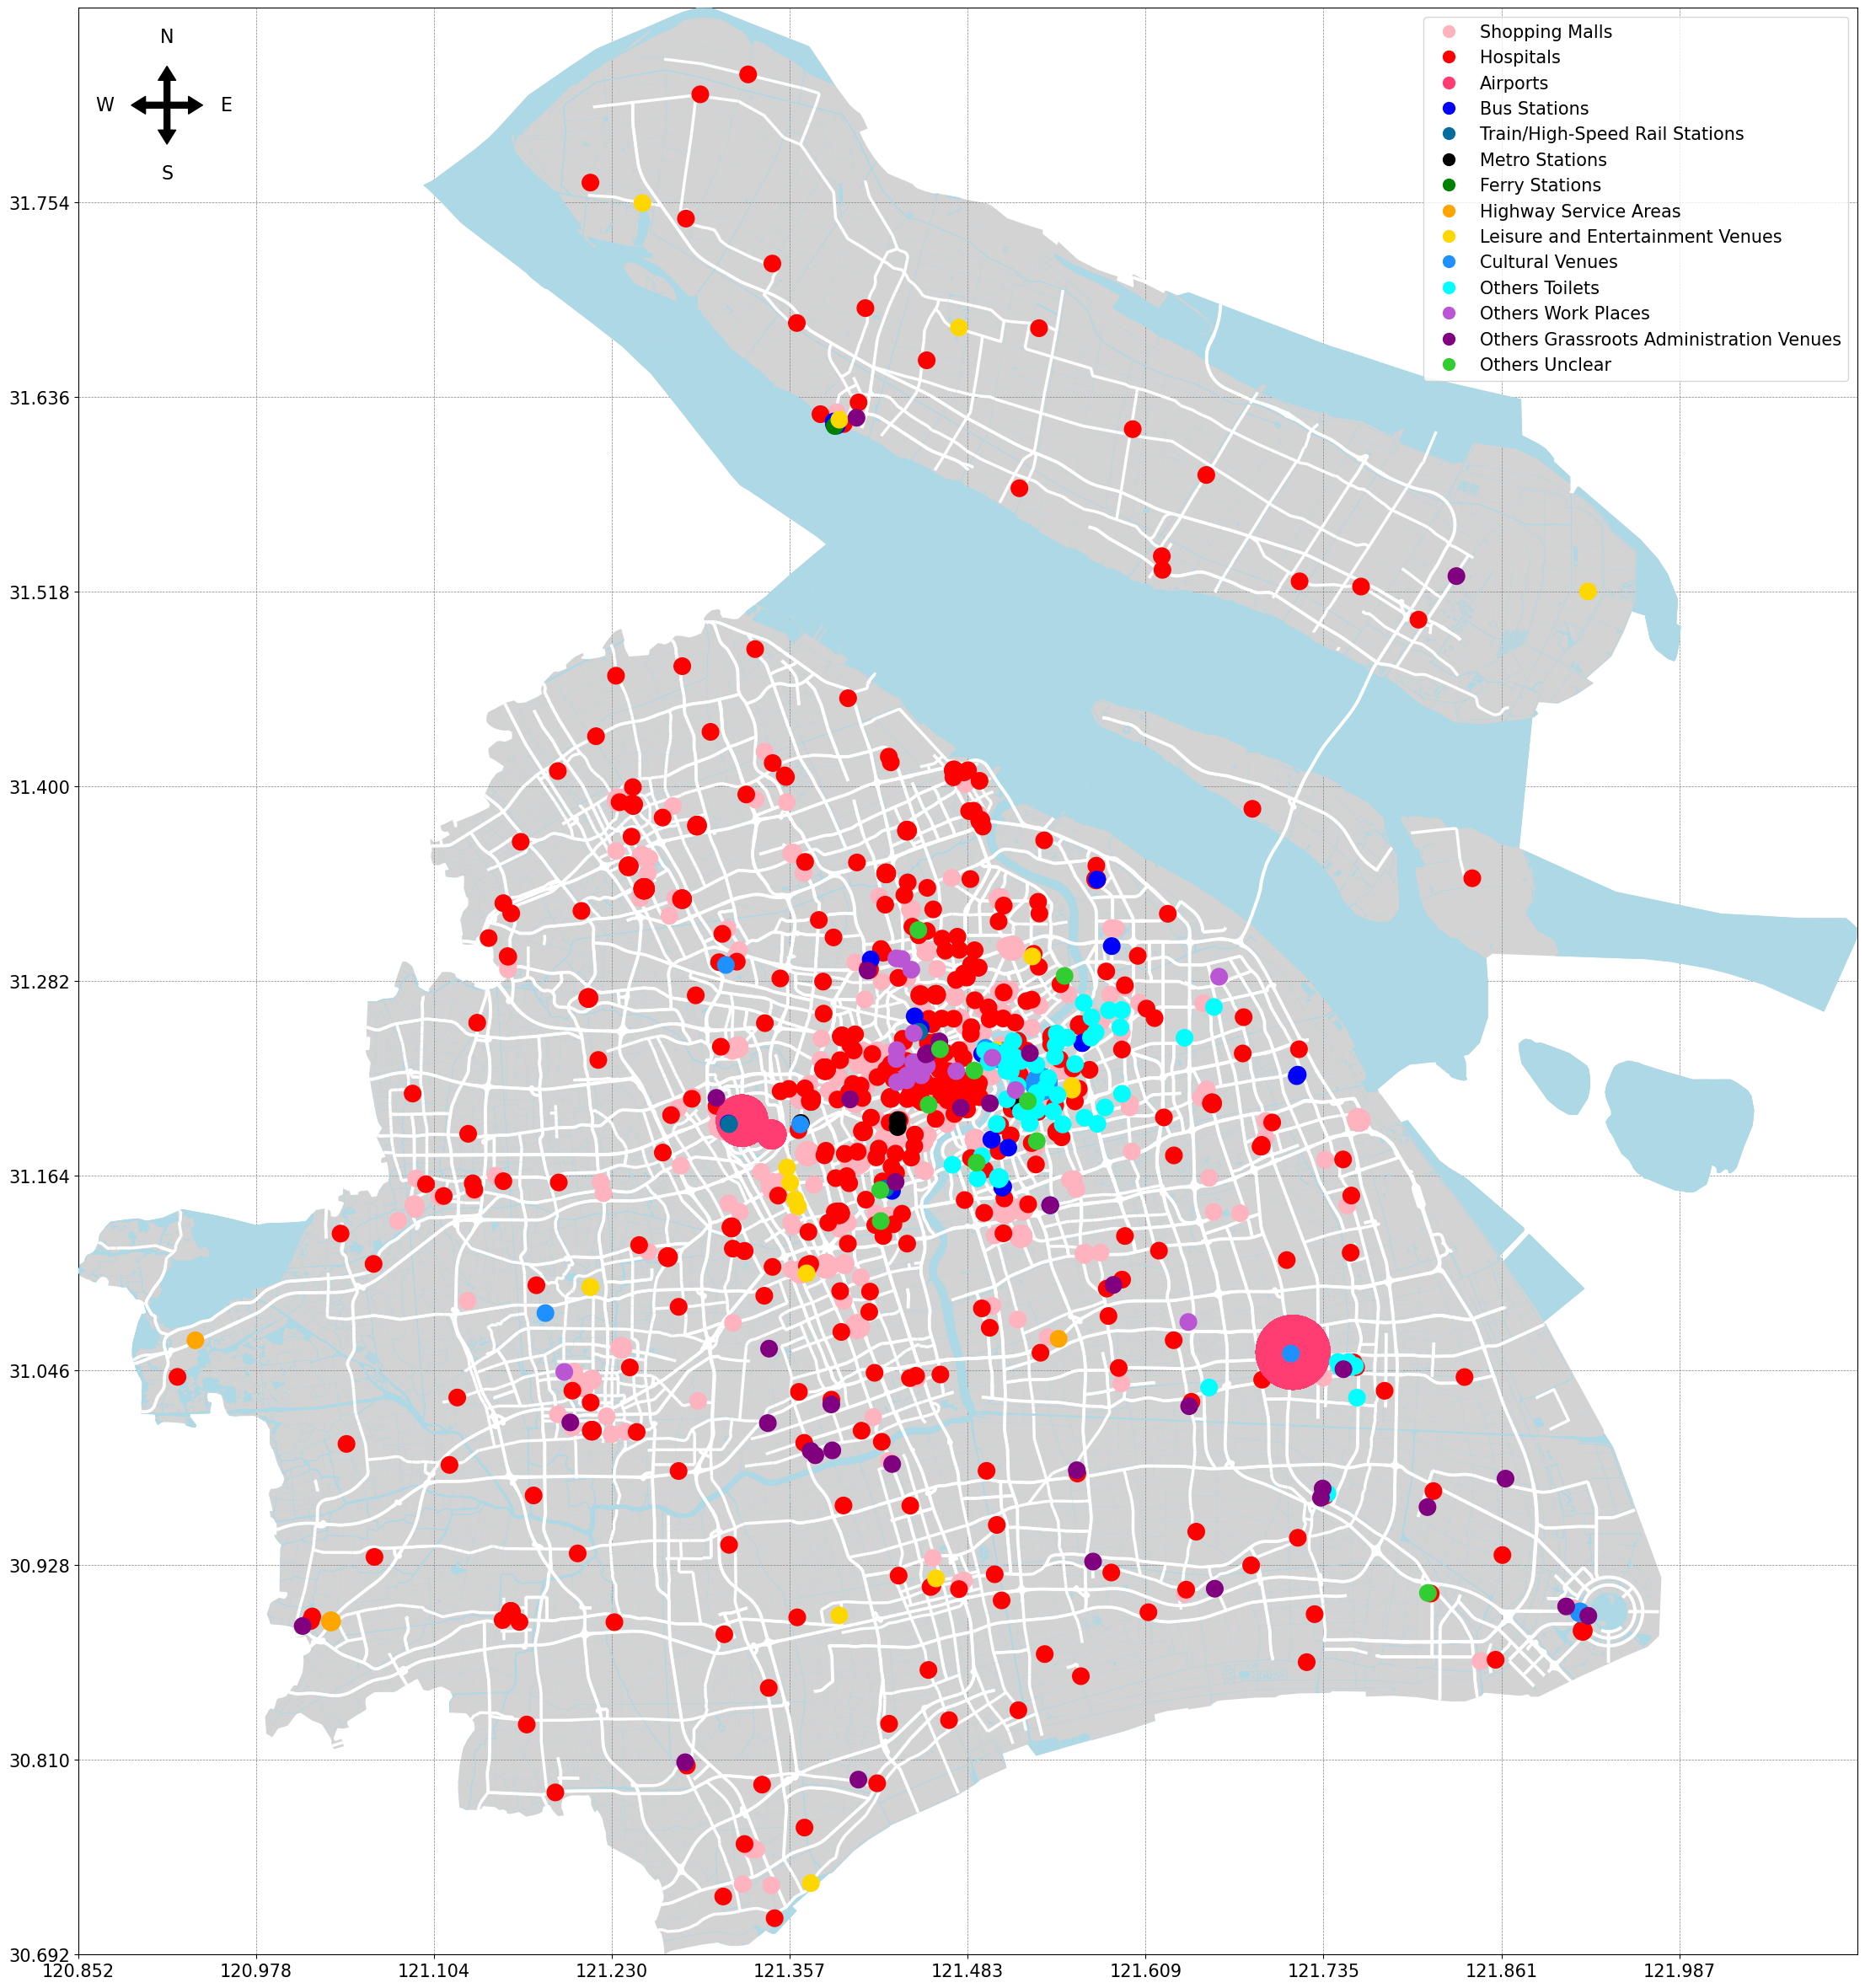

In [101]:
fig, ax = plt.subplots(figsize=(35, 30))

boundary.plot(ax=ax, edgecolor='none', facecolor='#d3d3d3', zorder=1)  # 绘制地图边界
water.plot(ax=ax, edgecolor='none', facecolor='#add8e6', zorder=2)      # 绘制水体
river.plot(ax=ax, edgecolor='none', facecolor='#add8e6', zorder=3)      # 绘制河流

road.plot(ax=ax, edgecolor='white', linewidth=2.5, zorder=4)            # 绘制道路，白色线条，加粗

minx, miny, maxx, maxy = boundary.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

base_size = 150
size_multiplier = 50

legend_elements = [] 

for label, df in filtered_data_frames.items():
    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df['longitude_wgs84'], df['latitude_wgs84']),
        crs='EPSG:4326'
    )
    
    coords_count = gdf['geometry'].value_counts()
    
    sizes = [base_size + size_multiplier * count for count in coords_count[gdf['geometry']]]
    
    gdf.plot(ax=ax, marker='o', color=color_map[label], markersize=sizes, label=label, zorder=5)

    legend_elements.append(Line2D([0], [0], marker='o', color=color_map[label], label=label, markersize=10, linestyle='None'))

ax.set_axis_on()
ax.set_xticks(np.arange(minx, maxx, step=(maxx-minx)/10)) 
ax.set_yticks(np.arange(miny, maxy, step=(maxy-miny)/10))
ax.grid(which='both', color='gray', linestyle='--', linewidth=0.5)

compass_x = 0.05
compass_y = 0.95
ax.annotate('', xy=(compass_x, compass_y - 0.02), xycoords='axes fraction', xytext=(compass_x, compass_y), 
            arrowprops=dict(facecolor='black', width=5, headwidth=15))
ax.annotate('', xy=(compass_x + 0.02, compass_y), xycoords='axes fraction', xytext=(compass_x, compass_y), 
            arrowprops=dict(facecolor='black', width=5, headwidth=15))
ax.annotate('', xy=(compass_x - 0.02, compass_y), xycoords='axes fraction', xytext=(compass_x, compass_y), 
            arrowprops=dict(facecolor='black', width=5, headwidth=15))
ax.annotate('', xy=(compass_x, compass_y + 0.02), xycoords='axes fraction', xytext=(compass_x, compass_y), 
            arrowprops=dict(facecolor='black', width=5, headwidth=15))
ax.text(compass_x, compass_y + 0.03, 'N', ha='center', va='bottom', transform=ax.transAxes, fontsize=16)
ax.text(compass_x, compass_y - 0.03, 'S', ha='center', va='top', transform=ax.transAxes, fontsize=16)
ax.text(compass_x + 0.03, compass_y, 'E', ha='left', va='center', transform=ax.transAxes, fontsize=16)
ax.text(compass_x - 0.03, compass_y, 'W', ha='right', va='center', transform=ax.transAxes, fontsize=16)

ax.legend(handles=legend_elements, fontsize=15, title_fontsize='15')

plt.savefig('output/figure 4.9.png', dpi=300, bbox_inches='tight')

plt.show()

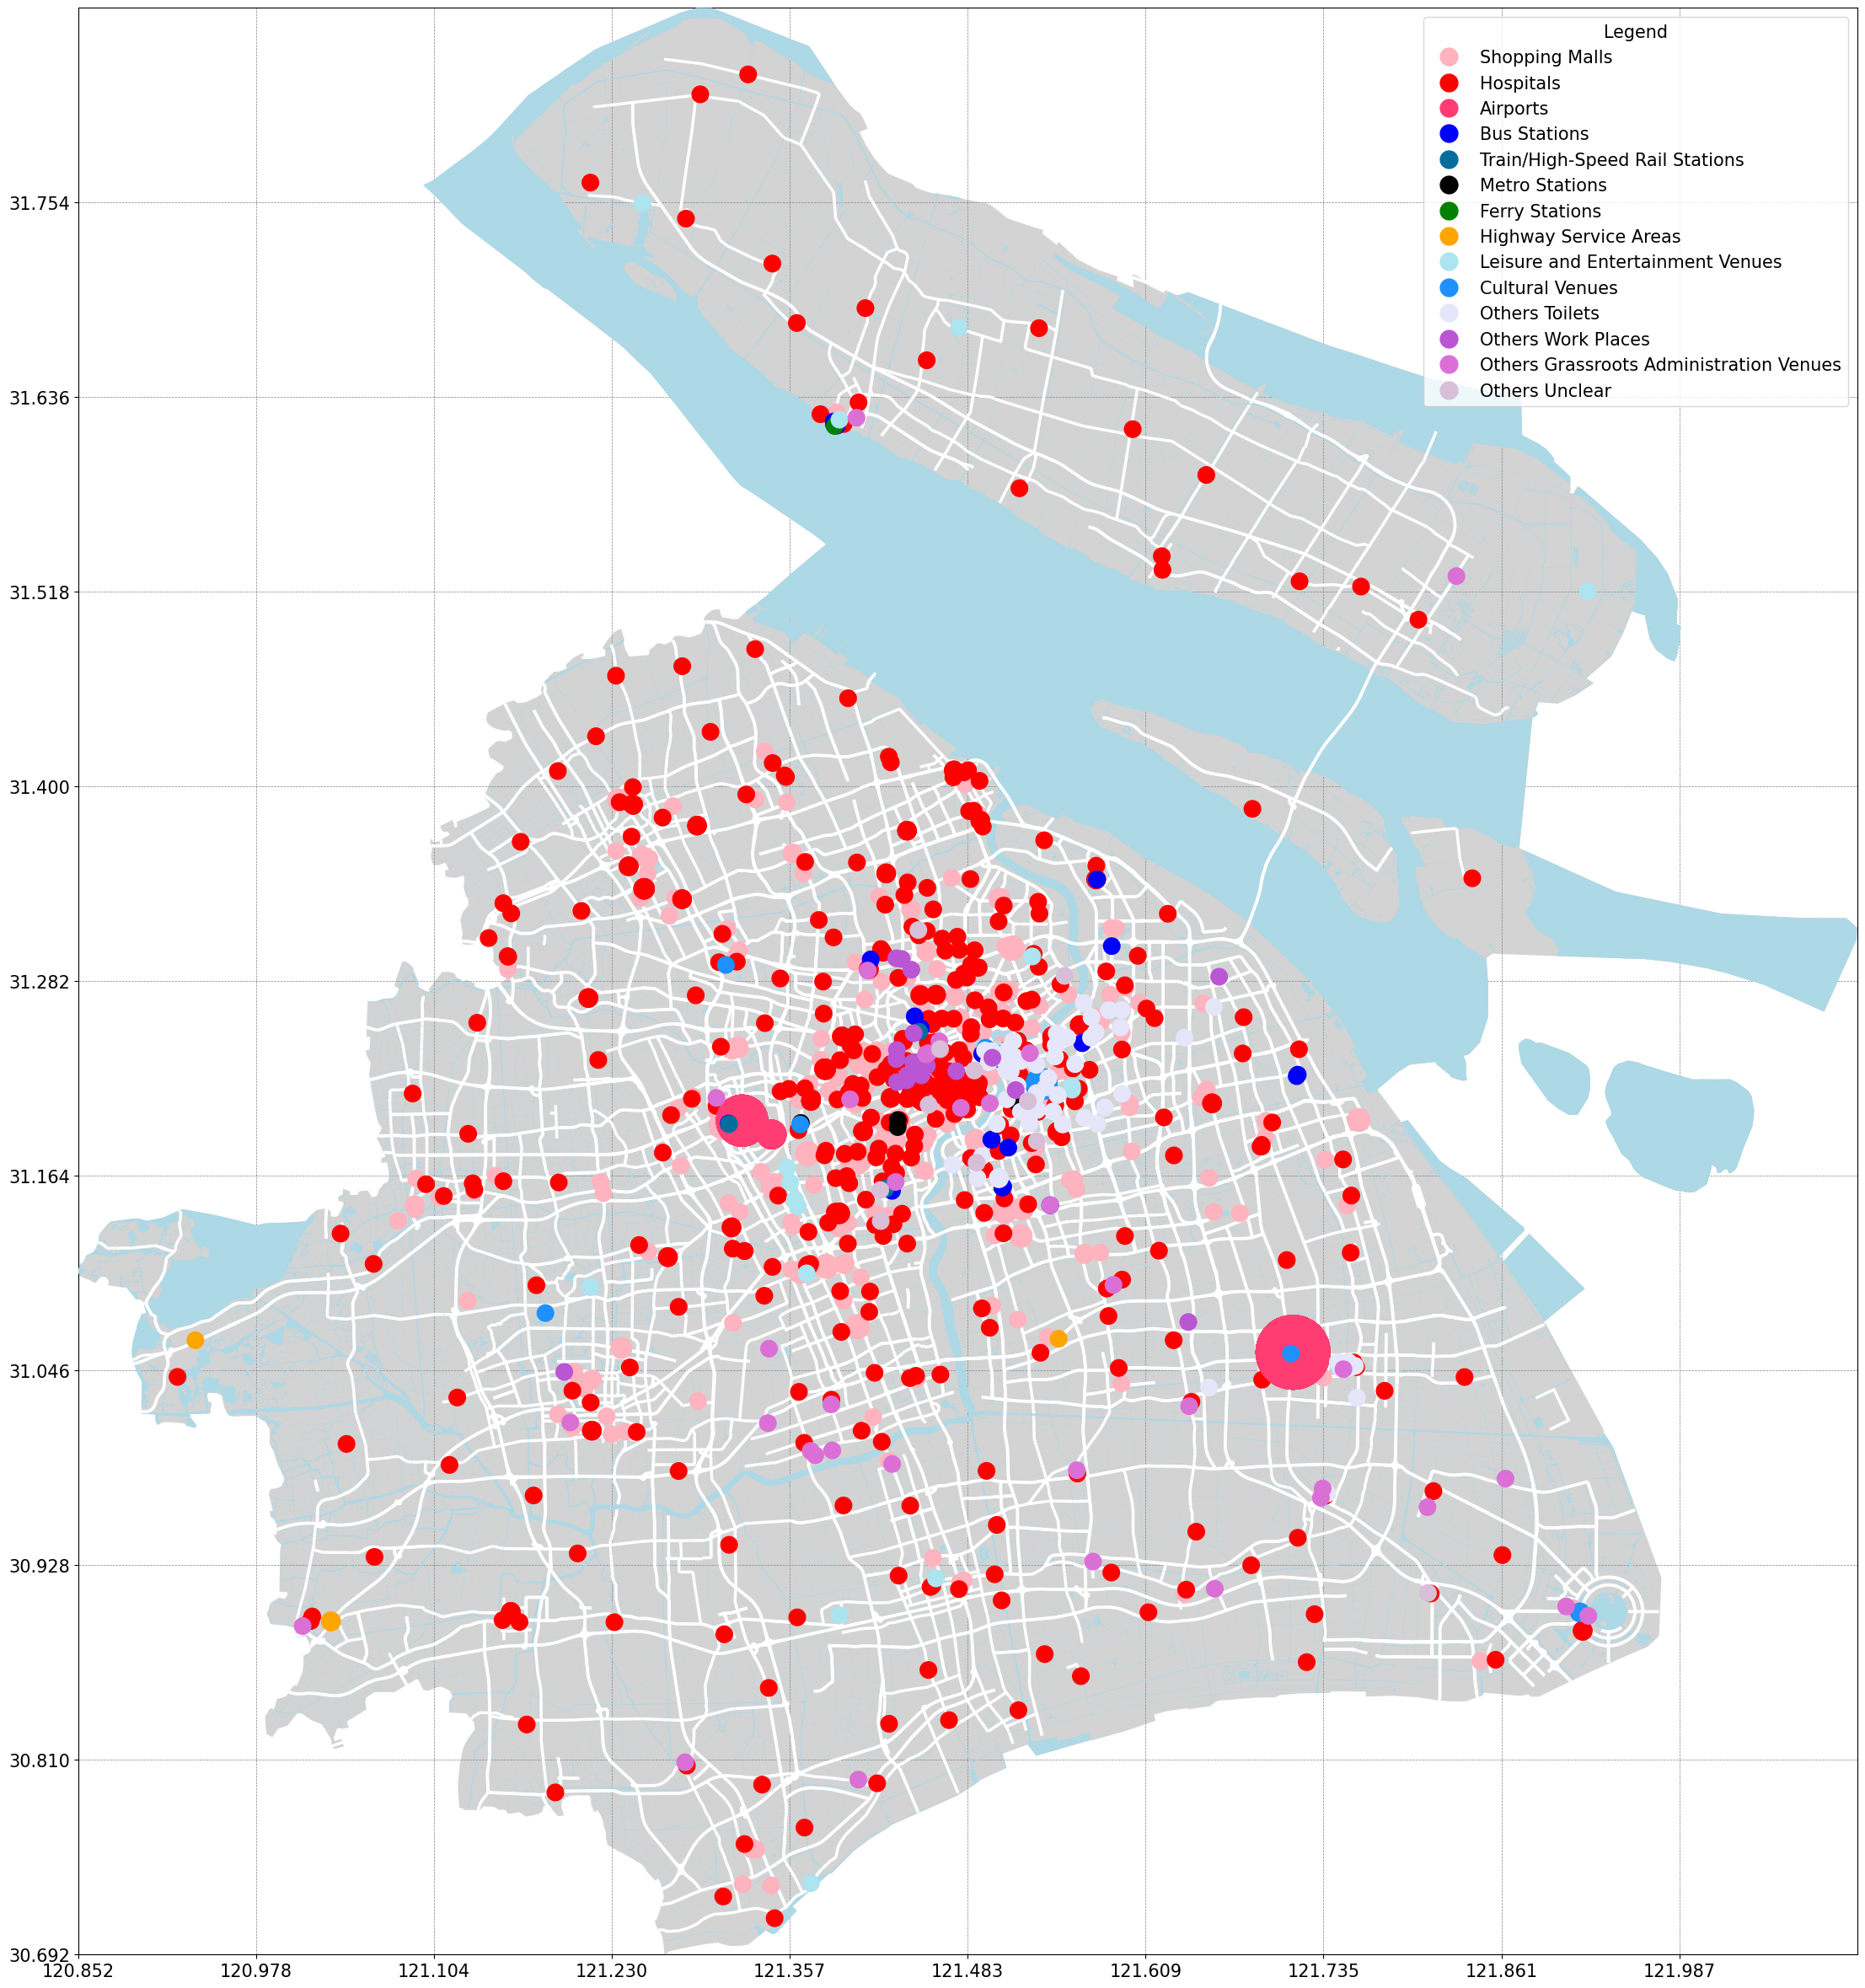

In [85]:
plt.rcParams['font.size'] = 15

fig, ax = plt.subplots(figsize=(35, 30))

boundary.plot(ax=ax, edgecolor='none', facecolor='#d3d3d3', zorder=1) 
water.plot(ax=ax, edgecolor='none', facecolor='#add8e6', zorder=2)  
river.plot(ax=ax, edgecolor='none', facecolor='#add8e6', zorder=3)     

road.plot(ax=ax, edgecolor='white', linewidth=2.5, zorder=4)           

minx, miny, maxx, maxy = boundary.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

base_size = 150
size_multiplier = 50

legend_elements = [] 

for label, df in filtered_data_frames.items():
    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df['longitude_wgs84'], df['latitude_wgs84']),
        crs='EPSG:4326'
    )
    
    coords_count = gdf['geometry'].value_counts()
    
    sizes = [base_size + size_multiplier * count for count in coords_count[gdf['geometry']]]
    
    gdf.plot(ax=ax, marker='o', color=color_map[label], markersize=sizes, label=label, zorder=5)

    legend_elements.append(Line2D([0], [0], marker='o', color=color_map[label], label=label, markersize=15, linestyle='None')) 

ax.set_axis_on()
ax.set_xticks(np.arange(minx, maxx, step=(maxx-minx)/10))
ax.set_yticks(np.arange(miny, maxy, step=(maxy-miny)/10))
ax.grid(which='both', color='gray', linestyle='--', linewidth=0.5)

ax.legend(handles=legend_elements, fontsize=15, title='Legend', title_fontsize='15')  # 增加图例的字体大小

plt.savefig('output/figure 4.9.png', dpi=300, bbox_inches='tight')

plt.show()

In [125]:
population_density_path = 'Data_1/population_density.csv'
population_density = pd.read_csv(population_density_path, encoding='utf-8-sig')
population_density.shape

(242, 4)

In [126]:
bcr_path = 'Data_1/shanghai_bcr.csv'
bcr_2023 = pd.read_csv(bcr_path, encoding='utf-8-sig')

bcr_2023_1 = bcr_2023.copy()

print(bcr_2023_1.head(5))

  name     location   location_1 date         time services   longitude  \
0  合生汇  翔殷路1099号L1层  翔殷路1099号L1层  1-7  10:00-22:00      母婴室  121.525085   
1  合生汇  翔殷路1099号L3层  翔殷路1099号L3层  1-7  10:00-22:00      母婴室  121.525085   
2  合生汇  翔殷路1099号L4层  翔殷路1099号L4层  1-7  10:00-22:00      母婴室  121.525085   
3  合生汇  翔殷路1099号L5层  翔殷路1099号L5层  1-7  10:00-22:00      母婴室  121.525085   
4  合生汇  翔殷路1099号B2层  翔殷路1099号B2层  1-7  10:00-22:00      母婴室  121.525085   

    latitude  
0  31.305877  
1  31.305877  
2  31.305877  
3  31.305877  
4  31.305877  


In [127]:
bcr_2023_1[['longitude_wgs84', 'latitude_wgs84']] = bcr_2023_1.apply(
    lambda row: bd09_to_wgs84(row['longitude'], row['latitude']), axis=1, result_type='expand'
)

bcr_2023_1.head()

name     location   location_1 date         time services   longitude  \
0  合生汇  翔殷路1099号L1层  翔殷路1099号L1层  1-7  10:00-22:00      母婴室  121.525085   
1  合生汇  翔殷路1099号L3层  翔殷路1099号L3层  1-7  10:00-22:00      母婴室  121.525085   
2  合生汇  翔殷路1099号L4层  翔殷路1099号L4层  1-7  10:00-22:00      母婴室  121.525085   
3  合生汇  翔殷路1099号L5层  翔殷路1099号L5层  1-7  10:00-22:00      母婴室  121.525085   
4  合生汇  翔殷路1099号B2层  翔殷路1099号B2层  1-7  10:00-22:00      母婴室  121.525085   

    latitude  longitude_wgs84  latitude_wgs84  
0  31.305877       121.514178        31.30213  
1  31.305877       121.514178        31.30213  
2  31.305877       121.514178        31.30213  
3  31.305877       121.514178        31.30213  
4  31.305877       121.514178        31.30213

In [128]:
bcr_2023_1 = bcr_2023_1[~((bcr_2023_1['longitude'] == 0.000000) & (bcr_2023_1['latitude'] == 0.000000))]

In [130]:
population_density = population_density[~population_density['type'].str.contains("区")]

In [131]:
population_density.head()

name type  population  density
1  南京东路街道   街道       69826  29141.0
2    外滩街道   街道       52188  23855.0
3  半淞园路街道   街道      115278  40417.0
4   小东门街道   街道       53497  20360.0
5    豫园街道   街道       32083  26809.0

In [132]:
boundary_d_path = "上海市_乡镇边界.shp"
boundary_d = gpd.read_file(boundary_d_path)
boundary_d.shape

(229, 6)

In [133]:
merged_data = boundary_d.merge(population_density, left_on='name', right_on='name', how='left')

print(merged_data.head())

   OBJECTID   name     area_code  Shape_Le_1  Shape_Area  \
0         1    祝桥镇           NaN    1.445870    0.022457   
1         2    新浜镇  310117117000    0.364798    0.004223   
2         3  嘉定工业区  310114501000    0.220200    0.001015   
3         4  曲阳路街道  310109010000    0.075814    0.000289   
4         5   田林街道  310104011000    0.098985    0.000381   

                                            geometry    type  population  \
0  MULTIPOLYGON (((121.77540 31.21341, 121.78831 ...       镇    223323.0   
1  POLYGON ((121.04233 30.97186, 121.04244 30.971...       镇     26115.0   
2  MULTIPOLYGON (((121.25308 31.37688, 121.25363 ...  类似乡级单位     73937.0   
3  POLYGON ((121.49638 31.29714, 121.49680 31.296...      街道    107749.0   
4  POLYGON ((121.41921 31.19341, 121.41982 31.192...      街道    101489.0   

   density  
0   1212.0  
1    583.6  
2   4818.0  
3    35387  
4  25148.0  


In [134]:
missing_density = merged_data[merged_data['density'].isnull()]
print(f"Number of unmatched entries: {len(missing_density)}")
if len(missing_density) > 0:
    print("Unmatched entries found:")
    print(missing_density[['name', 'density']])  

Number of unmatched entries: 7
Unmatched entries found:
                    name density
68                  五角场镇     NaN
78             金桥经济技术开发区     NaN
82               张江高科技园区     NaN
83               菊园新区管委会     NaN
88                  金海社区     NaN
149  中国（上海）自由贸易试验区（保税片区）     NaN
155          上海市奉贤区海湾旅游区     NaN


/tmp/ipykernel_4290/2868932224.py:15: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='upper right')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


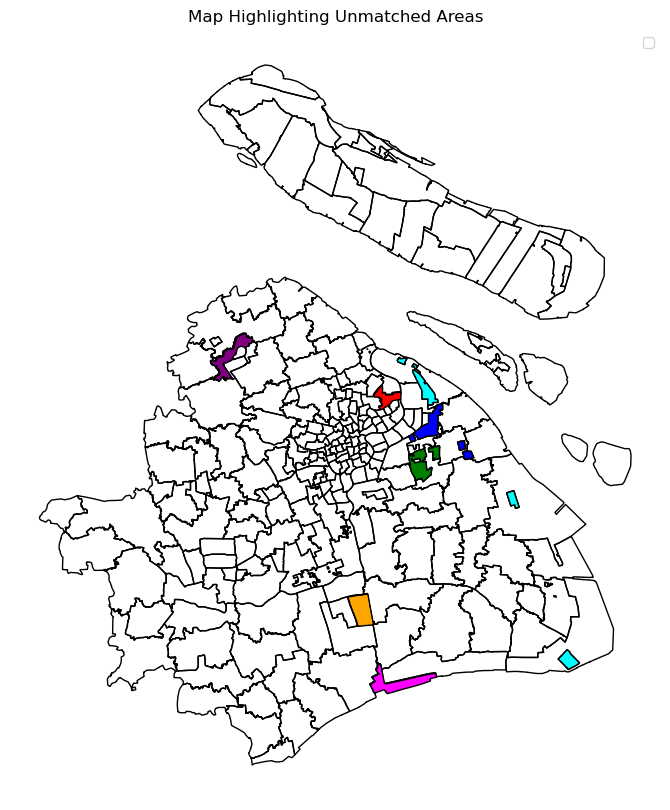

In [135]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

boundary_d.plot(ax=ax, color='none', edgecolor='black')

colors = ['red', 'blue', 'green', 'purple', 'orange', 'cyan', 'magenta']
for i, (idx, row) in enumerate(missing_density.iterrows()):
    area = boundary_d[boundary_d['name'] == row['name']]
    if not area.empty:
        area.plot(ax=ax, color=colors[i % len(colors)], edgecolor='black', label=row['name'])

plt.legend(loc='upper right')

ax.set_title('Map Highlighting Unmatched Areas')
ax.set_axis_off()

plt.show()

In [136]:
name_corrections = {
    '五角场镇': '长海路街道',
    '菊园新区管委会': '菊园新区',
    '金海社区': '金海街道',
    '上海市奉贤区海湾旅游区': '海湾旅游区'
}
boundary_d['name'] = boundary_d['name'].replace(name_corrections)

merged_data = boundary_d.merge(population_density, on='name', how='left')

missing_density = merged_data[merged_data['density'].isnull()]  # 重新生成 missing_density
print(f"Number of unmatched entries after corrections: {len(missing_density)}")
if len(missing_density) > 0:
    print("Unmatched entries found after all corrections:")
    print(missing_density[['name', 'density']])

Number of unmatched entries after corrections: 3
Unmatched entries found after all corrections:
                    name density
78             金桥经济技术开发区     NaN
82               张江高科技园区     NaN
149  中国（上海）自由贸易试验区（保税片区）     NaN


In [137]:
merged_data['density'] = merged_data['density'].astype('float64')

In [138]:
print(merged_data['density'].dtype)

float64


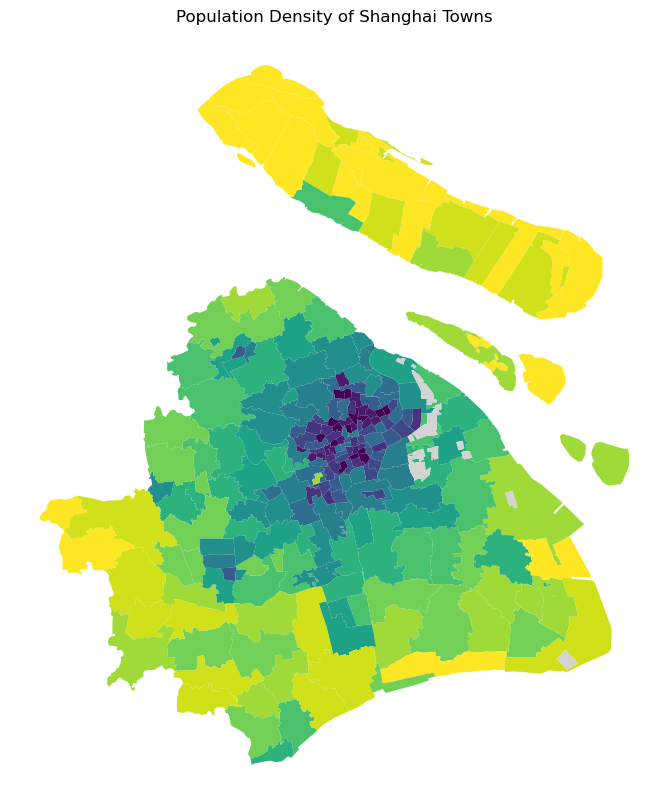

In [139]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

color_map = 'viridis_r'
na_color = 'lightgrey' 

merged_data.plot(column='density', ax=ax,
                 cmap=color_map, missing_kwds={
                     "color": na_color,
                     "label": "人口密度不详",
                 },
                 scheme='quantiles', k=15) 

ax.set_title('Population Density of Shanghai Towns')
ax.set_axis_off()

plt.show()

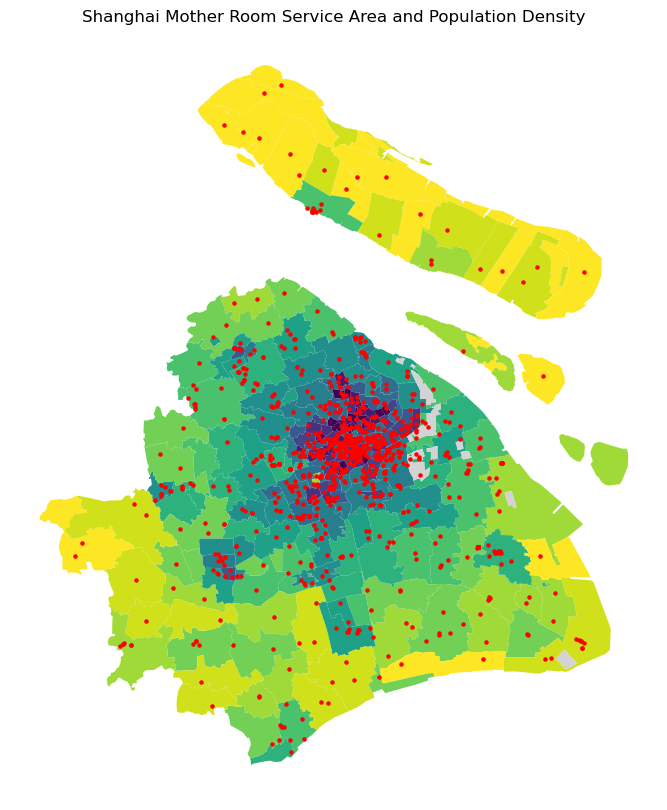

In [143]:
gdf = gpd.GeoDataFrame(
    bcr_2023_1,
    geometry=gpd.points_from_xy(bcr_2023_1.longitude_wgs84, bcr_2023_1.latitude_wgs84)
)
gdf.set_crs('epsg:4326', inplace=True) 


fig, ax = plt.subplots(1, 1, figsize=(12, 10))


merged_data.plot(column='density', ax=ax,
                 cmap=color_map, missing_kwds={
                     "color": na_color,
                     "label": "人口密度不详",
                 },
                 scheme='quantiles', k=15) 

gdf.plot(ax=ax, color='red', markersize=5)

ax.set_title('Shanghai Mother Room Service Area and Population Density')
ax.set_axis_off()

plt.show()

In [144]:
print(merged_data.head())

   OBJECTID   name     area_code  Shape_Le_1  Shape_Area  \
0         1    祝桥镇           NaN    1.445870    0.022457   
1         2    新浜镇  310117117000    0.364798    0.004223   
2         3  嘉定工业区  310114501000    0.220200    0.001015   
3         4  曲阳路街道  310109010000    0.075814    0.000289   
4         5   田林街道  310104011000    0.098985    0.000381   

                                            geometry    type  population  \
0  MULTIPOLYGON (((121.77540 31.21341, 121.78831 ...       镇    223323.0   
1  POLYGON ((121.04233 30.97186, 121.04244 30.971...       镇     26115.0   
2  MULTIPOLYGON (((121.25308 31.37688, 121.25363 ...  类似乡级单位     73937.0   
3  POLYGON ((121.49638 31.29714, 121.49680 31.296...      街道    107749.0   
4  POLYGON ((121.41921 31.19341, 121.41982 31.192...      街道    101489.0   

   density  
0   1212.0  
1    583.6  
2   4818.0  
3  35387.0  
4  25148.0  


In [145]:
print(gdf.head())

  name     location   location_1 date         time services   longitude  \
0  合生汇  翔殷路1099号L1层  翔殷路1099号L1层  1-7  10:00-22:00      母婴室  121.525085   
1  合生汇  翔殷路1099号L3层  翔殷路1099号L3层  1-7  10:00-22:00      母婴室  121.525085   
2  合生汇  翔殷路1099号L4层  翔殷路1099号L4层  1-7  10:00-22:00      母婴室  121.525085   
3  合生汇  翔殷路1099号L5层  翔殷路1099号L5层  1-7  10:00-22:00      母婴室  121.525085   
4  合生汇  翔殷路1099号B2层  翔殷路1099号B2层  1-7  10:00-22:00      母婴室  121.525085   

    latitude  longitude_wgs84  latitude_wgs84                    geometry  
0  31.305877       121.514178        31.30213  POINT (121.51418 31.30213)  
1  31.305877       121.514178        31.30213  POINT (121.51418 31.30213)  
2  31.305877       121.514178        31.30213  POINT (121.51418 31.30213)  
3  31.305877       121.514178        31.30213  POINT (121.51418 31.30213)  
4  31.305877       121.514178        31.30213  POINT (121.51418 31.30213)  


In [146]:
print(merged_data.columns)

Index(['OBJECTID', 'name', 'area_code', 'Shape_Le_1', 'Shape_Area', 'geometry',
       'type', 'population', 'density'],
      dtype='object')


In [149]:
gdf = gdf.to_crs(epsg=32651)
from geopandas.tools import sjoin

joined_data = sjoin(merged_data, gdf, how='left', op='contains')

mother_rooms_count = joined_data.groupby(joined_data.index)['geometry'].count()

merged_data['mother_rooms_count'] = mother_rooms_count

/opt/conda/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [150]:
print(merged_data.columns)

Index(['OBJECTID', 'name', 'area_code', 'Shape_Le_1', 'Shape_Area', 'geometry',
       'type', 'population', 'density', 'mother_rooms_count'],
      dtype='object')


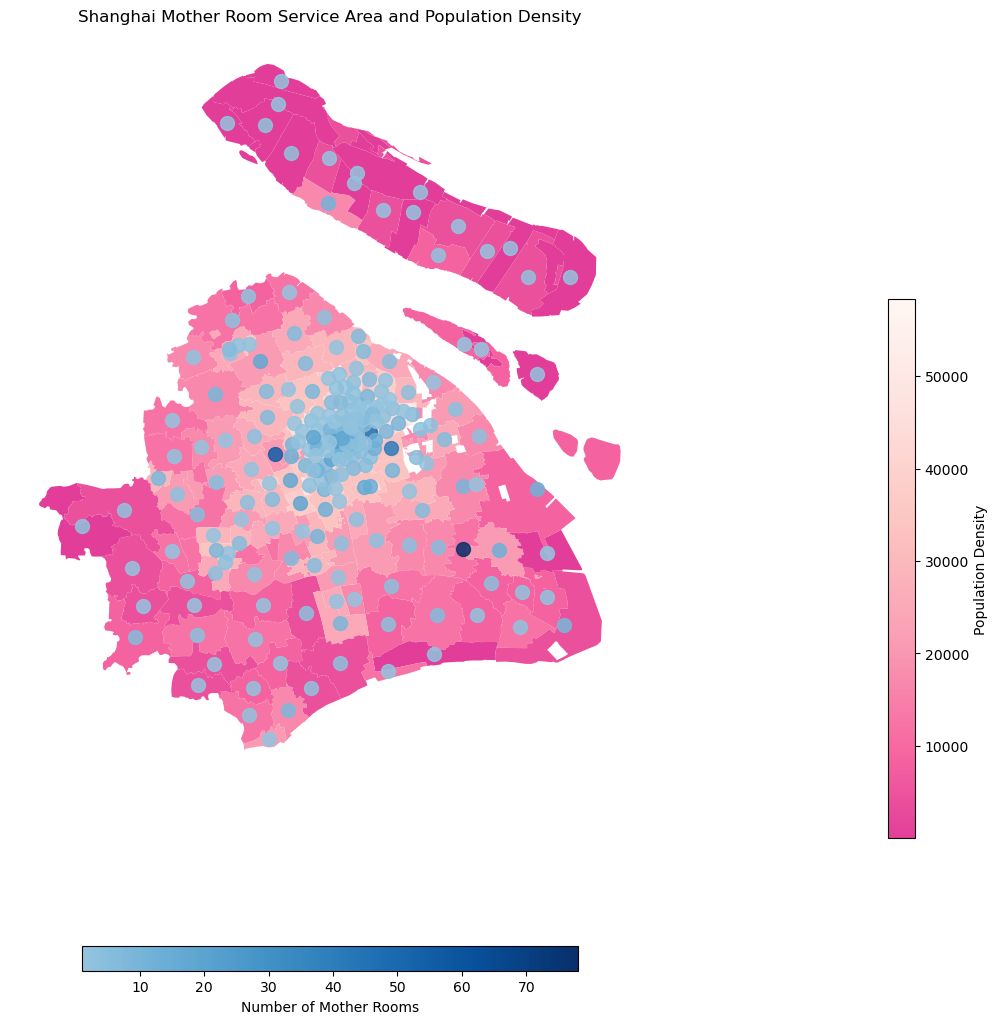

In [167]:
merged_data = merged_data.to_crs(epsg=32651)

fig, ax = plt.subplots(1, 1, figsize=(16, 14))

original_cmap_blues = plt.cm.RdPu_r
colors_blues = original_cmap_blues(np.linspace(0.4, 1, 256))
new_cmap_blues = matplotlib.colors.LinearSegmentedColormap.from_list("truncated_Blues", colors_blues)

density_plot = merged_data.plot(column='density', ax=ax, cmap=new_cmap_blues, legend=False,
                                scheme='quantiles', k=15)

centers = merged_data.geometry.centroid
room_points = gpd.GeoDataFrame(geometry=centers)

original_cmap_pink = plt.cm.Blues
colors_pinks = original_cmap_pink(np.linspace(0.4, 1, 256))
new_cmap_pinks = matplotlib.colors.LinearSegmentedColormap.from_list("truncated_Pinks", colors_pinks)

norm = matplotlib.colors.Normalize(vmin=merged_data['mother_rooms_count'].min(), vmax=merged_data['mother_rooms_count'].max())
room_points['color'] = merged_data['mother_rooms_count'].apply(lambda x: new_cmap_pinks(norm(x)))

for idx, point in room_points.iterrows():
    ax.plot(point.geometry.x, point.geometry.y, 'o', color=point['color'], markersize=10, alpha=0.85)

ax.set_title('Shanghai Mother Room Service Area and Population Density')
ax.set_axis_off()

sm_density = plt.cm.ScalarMappable(cmap=new_cmap_blues, norm=plt.Normalize(vmin=merged_data['density'].min(), vmax=merged_data['density'].max()))
sm_density._A = []
fig.colorbar(sm_density, ax=ax, orientation='vertical', label='Population Density', shrink=0.5)

sm_rooms = plt.cm.ScalarMappable(cmap=new_cmap_pinks, norm=norm)
sm_rooms._A = []
fig.colorbar(sm_rooms, ax=ax, orientation='horizontal', label='Number of Mother Rooms', shrink=0.5)

plt.show()